In [3]:
#Import all the required libraries. Numpy and Pandas for data analysis and Seaborn and Malplotlib for Visualization.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#Later on I will import more libraries as required
#VAR PDF helpful: http://www.fsb.miamioh.edu/lij14/672_2014_s7.pdf
#https://scholar.princeton.edu/sites/default/files/mikkelpm/files/lp_var.pdf

In [4]:
#Import the CSV file with annual data on variables from 1990

dataset = pd.read_csv("KSAEcon10.csv", parse_dates=['date'], index_col='date')

Variable	1SD Shock as per Impulse Response																
KSAGDPC	11.6%		1 SD Drop 2020 for VAR? And regression to get another scenario where input into VAR is changed														
MANU	3.7%		1 SD Drop 2020														
CONCOF	0.6%		1 SD Drop 2020														
WGDP	1.3%		**-3% as per IMF in 2020 (more than 1SD for Covid19)														
GUNCERT	36.9%		**Increased by 1SD - has negative relationship														
WTIPrice	24.3%		**Average taken as arbitrary $20 - more than 1SD drop (65% drop in 2019 average price)														
IMPORT	15.3%		**2019 down by 1.5% https://www.ceicdata.com/en/indicator/saudi-arabia/total-imports    whereas 2020 down by 1SD?														
EXPORT	23.4%		**2019 down by 11.73%. ttps://www.ceicdata.com/en/indicator/saudi-arabia/total-exports. 2020 down by 65% only pricing in oil price and not production cuts														
GovConsExDef	12.5%		"**Down 22% Q1 2020 without lockdowns http://www.jadwa.com/en/researchsection/research/economic-research/budget-reports    Down 65% in line with oil price drop scenario taken
**Down 3.5% in 2019 compared to previous year
** Assuming split with defence remains constant as per prev years as data not available"														
GFIXEDCAP	11.3%					2019	175207		2018	165009	https://www.ceicdata.com/en/indicator/saudi-arabia/gross-fixed-capital-formation						
							0.06180269		GFIXEDCAP 2020 dropped by 1SD								
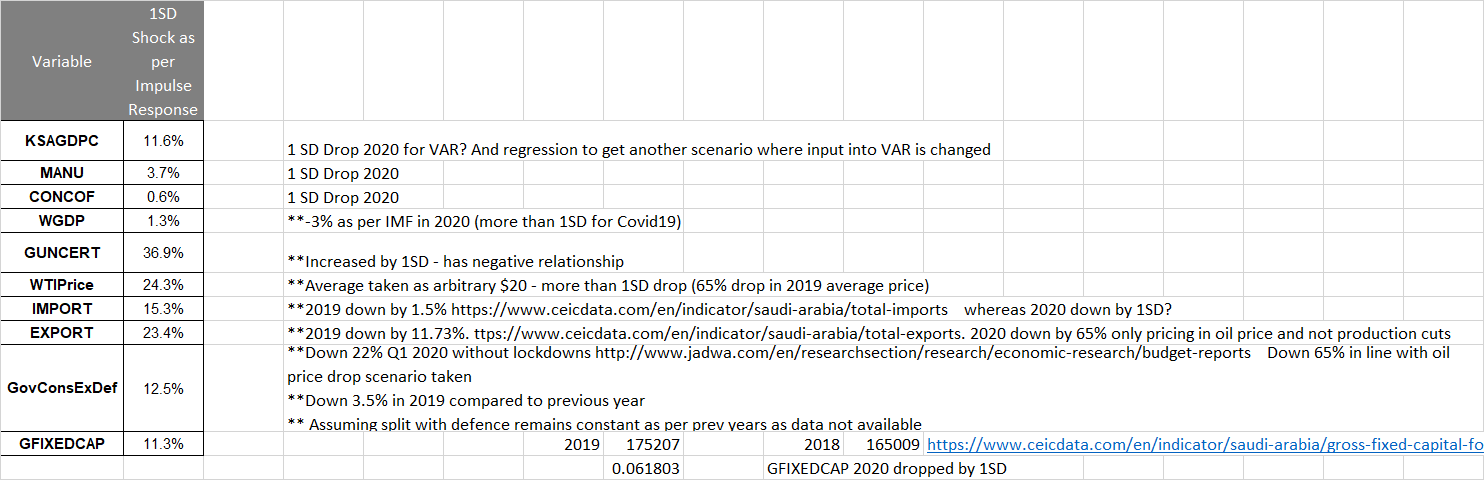

<h2> 1. Perform basic quality checks <h/2>

In [5]:
#Find Basic information about our dataset. Data types, size, column names and null values if any

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 25 columns):
KSAGDPC         31 non-null float64
MANU            31 non-null float64
SERV            29 non-null float64
CONCOF          31 non-null float64
BUILD           30 non-null float64
WGDP            31 non-null float64
WUNEMP          29 non-null float64
KSAUNEMP        29 non-null float64
KSAINFLAPCT     30 non-null float64
M2PCT           23 non-null float64
IRPCT           23 non-null float64
GUNCERT         31 non-null float64
NETX            31 non-null float64
WTIPrice        31 non-null float64
OilRentsPUB     31 non-null float64
OilRentsCALC    31 non-null float64
KSAGDPR         30 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
OILPRODTBD      30 non-null float64
OILPRODTBY      30 non-null float64
GOVTsLEND       21 non-null float64
GovConsExDef    31 non-null float64
InbTourExp      14 non-null float64
GFIXEDCAP    

In [6]:
#Some variables were shortlisted for being dropped based on previous iterations. There is also rationale behind dropping them.
#SERV moves with MANU (correlations can be plotted. There seemed to be issues with this measure)
#IRPCT follows the US Federal reserve due to maintenance of the PEG. US drives world GDP and WGDP vector is already in the system
#M2PCT is also in proportion to US Fed. US drives world GDP and WGDP vector is already in the system
#KSAINFLAPCT is not required as we are working with current GDP
#KSAUNEMP - this variable cannot be included until we fully understand what is being reported as part of it. For e.g. migrat unemployment
#WUNEMP is related to tourism but in case of KSA tourism, Emerging market UNEMP would be more relevant. Often divergence between Emerging vs. advanced, especially since 2007
#GOVTsLEND This is driven by government spending outlook and M2%
#OILRentsCALC has higher divergence from published numbers. The calc did not account for monthly variation in price
#BUILD excluded residential setor which is a key component. Only commercial and industrial BUILD data available
#NETX was dropped was IMPORt and EXPORT account for it in the system already
#Not enough rows for inboud tourism
# We are working with few rows so KSAGDPC accounts for both KSAGDPR and KSAINFLATPCT

dataset1=dataset.drop(['SERV','M2PCT','KSAINFLAPCT','KSAUNEMP', 'WUNEMP','IRPCT','GOVTsLEND', 'OilRentsCALC', 'BUILD', 'OilRentsPUB', 'NETX', 'OILPRODTBY', 'OILPRODTBD', 'KSAGDPR','InbTourExp'], axis=1)

In [7]:
#After dropping variables, we work with dataset1

dataset1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 10 columns):
KSAGDPC         31 non-null float64
MANU            31 non-null float64
CONCOF          31 non-null float64
WGDP            31 non-null float64
GUNCERT         31 non-null float64
WTIPrice        31 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
GovConsExDef    31 non-null float64
GFIXEDCAP       31 non-null float64
dtypes: float64(10)
memory usage: 2.7 KB


In [8]:
#Data ranks below average on completeness. Firstly, annual data does not capture the quarterly dynamics 
#that are key to forecast GDP in the short run. Additionally some variables were either unavailable or only
#available for purchase.
#finally, some variables might have to be dropped due to too few rows


In [9]:
#Next data quality check is for null values
dataset1.isnull().any()

KSAGDPC         False
MANU            False
CONCOF          False
WGDP            False
GUNCERT         False
WTIPrice        False
IMPORT          False
EXPORT          False
GovConsExDef    False
GFIXEDCAP       False
dtype: bool

In [10]:
dataset1.head(5)

KSAGDPC   MANU      CONCOF         WGDP    GUNCERT  WTIPrice  \
date                                                                          
1990-12-31  440.525368  85.07  100.636467  7171.438438  12334.384     24.53   
1991-12-31  495.176141  82.85  100.108033  7158.367658   8057.454     21.54   
1992-12-31  513.394098  86.18   99.632517  7172.132639  10183.929     20.58   
1993-12-31  497.964791  88.70   98.991400  7169.133917  12960.895     18.43   
1994-12-31  506.229950  92.00  100.183942  7272.894902  10129.384     17.20   

                  IMPORT        EXPORT  GovConsExDef     GFIXEDCAP  
date                                                                
1990-12-31  3.690441e+10  4.744593e+10       82234.0  8.325064e+10  
1991-12-31  4.811722e+10  5.065260e+10      109933.0  1.000000e+11  
1992-12-31  4.933138e+10  5.361068e+10       96333.0  1.040000e+11  
1993-12-31  4.448331e+10  4.567824e+10       79680.0  1.090000e+11  
1994-12-31  3.524059e+10  4.596075e+10       77049.0  9.300217e+10

In [11]:
dataset1.tail(5)

KSAGDPC       MANU      CONCOF         WGDP      GUNCERT  \
date                                                                       
2016-12-31  2418.508280  321.17000  100.355375  10473.74581  25888.22000   
2017-12-31  2582.198416  325.34000  100.581433  10685.56418  22786.65800   
2018-12-31  2949.456868  332.16000  100.627600  10891.00147  23607.30000   
2019-12-31  2973.625643  337.57000  100.007208  11206.84051  40648.57500   
2020-12-31  2628.685068  325.07991   99.407165  11061.15159  55647.89918   

            WTIPrice        IMPORT        EXPORT  GovConsExDef     GFIXEDCAP  
date                                                                          
2016-12-31     43.29  1.980000e+11  2.010000e+11    497976.000  6.320000e+11  
2017-12-31     50.80  2.020000e+11  2.400000e+11    502908.000  6.320000e+11  
2018-12-31     65.23  2.100000e+11  3.140000e+11    576996.000  6.130000e+11  
2019-12-31     56.99  2.070000e+11  2.770000e+11    556801.140  6.500000e+11  
2020-12-31     20.00  1.750000e+11  9.700873e+10    194880.399  5.770000e+11

In [12]:
#Drop missing values. This gives us dataset2

dataset2=dataset1.dropna()

In [13]:
dataset2.tail(5)

KSAGDPC       MANU      CONCOF         WGDP      GUNCERT  \
date                                                                       
2016-12-31  2418.508280  321.17000  100.355375  10473.74581  25888.22000   
2017-12-31  2582.198416  325.34000  100.581433  10685.56418  22786.65800   
2018-12-31  2949.456868  332.16000  100.627600  10891.00147  23607.30000   
2019-12-31  2973.625643  337.57000  100.007208  11206.84051  40648.57500   
2020-12-31  2628.685068  325.07991   99.407165  11061.15159  55647.89918   

            WTIPrice        IMPORT        EXPORT  GovConsExDef     GFIXEDCAP  
date                                                                          
2016-12-31     43.29  1.980000e+11  2.010000e+11    497976.000  6.320000e+11  
2017-12-31     50.80  2.020000e+11  2.400000e+11    502908.000  6.320000e+11  
2018-12-31     65.23  2.100000e+11  3.140000e+11    576996.000  6.130000e+11  
2019-12-31     56.99  2.070000e+11  2.770000e+11    556801.140  6.500000e+11  
2020-12-31     20.00  1.750000e+11  9.700873e+10    194880.399  5.770000e+11

In [14]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 10 columns):
KSAGDPC         31 non-null float64
MANU            31 non-null float64
CONCOF          31 non-null float64
WGDP            31 non-null float64
GUNCERT         31 non-null float64
WTIPrice        31 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
GovConsExDef    31 non-null float64
GFIXEDCAP       31 non-null float64
dtypes: float64(10)
memory usage: 2.7 KB


<h2> 2. Perform basic exploratory analysis and transformations <h/2>

C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


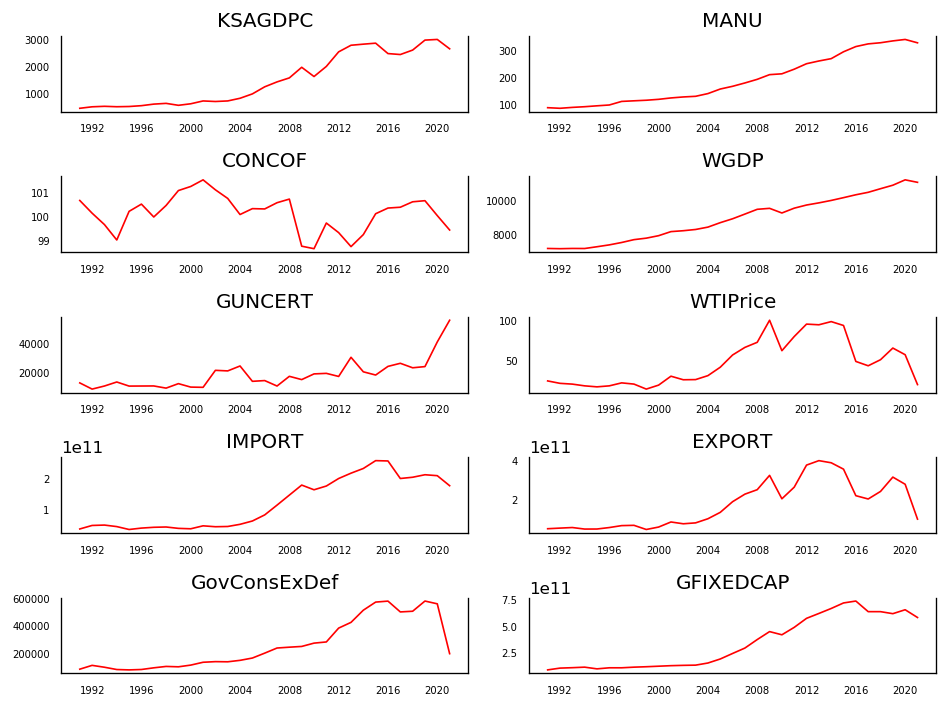

In [15]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset2[dataset2.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset2.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();


In [16]:
#Let's also visualize the percntage change. dataset4 is the new dataset after incorporating yoy change

dataset4 = dataset2.pct_change()

In [17]:
dataset4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 10 columns):
KSAGDPC         30 non-null float64
MANU            30 non-null float64
CONCOF          30 non-null float64
WGDP            30 non-null float64
GUNCERT         30 non-null float64
WTIPrice        30 non-null float64
IMPORT          30 non-null float64
EXPORT          30 non-null float64
GovConsExDef    30 non-null float64
GFIXEDCAP       30 non-null float64
dtypes: float64(10)
memory usage: 2.7 KB


In [18]:
#Drop NA (if any) due to PCT change. Gives us dataset5

dataset5=dataset4.dropna()

In [19]:
dataset5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1991-12-31 to 2020-12-31
Data columns (total 10 columns):
KSAGDPC         30 non-null float64
MANU            30 non-null float64
CONCOF          30 non-null float64
WGDP            30 non-null float64
GUNCERT         30 non-null float64
WTIPrice        30 non-null float64
IMPORT          30 non-null float64
EXPORT          30 non-null float64
GovConsExDef    30 non-null float64
GFIXEDCAP       30 non-null float64
dtypes: float64(10)
memory usage: 2.6 KB


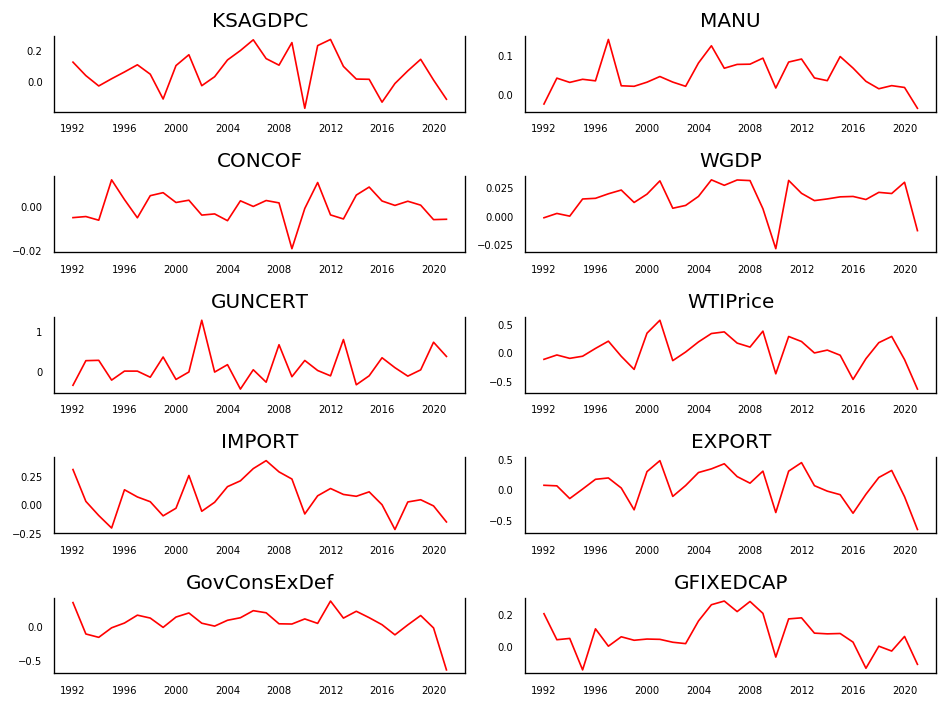

In [20]:
# Plot dataset 5 to visualize the variables
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset5[dataset5.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset5.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();


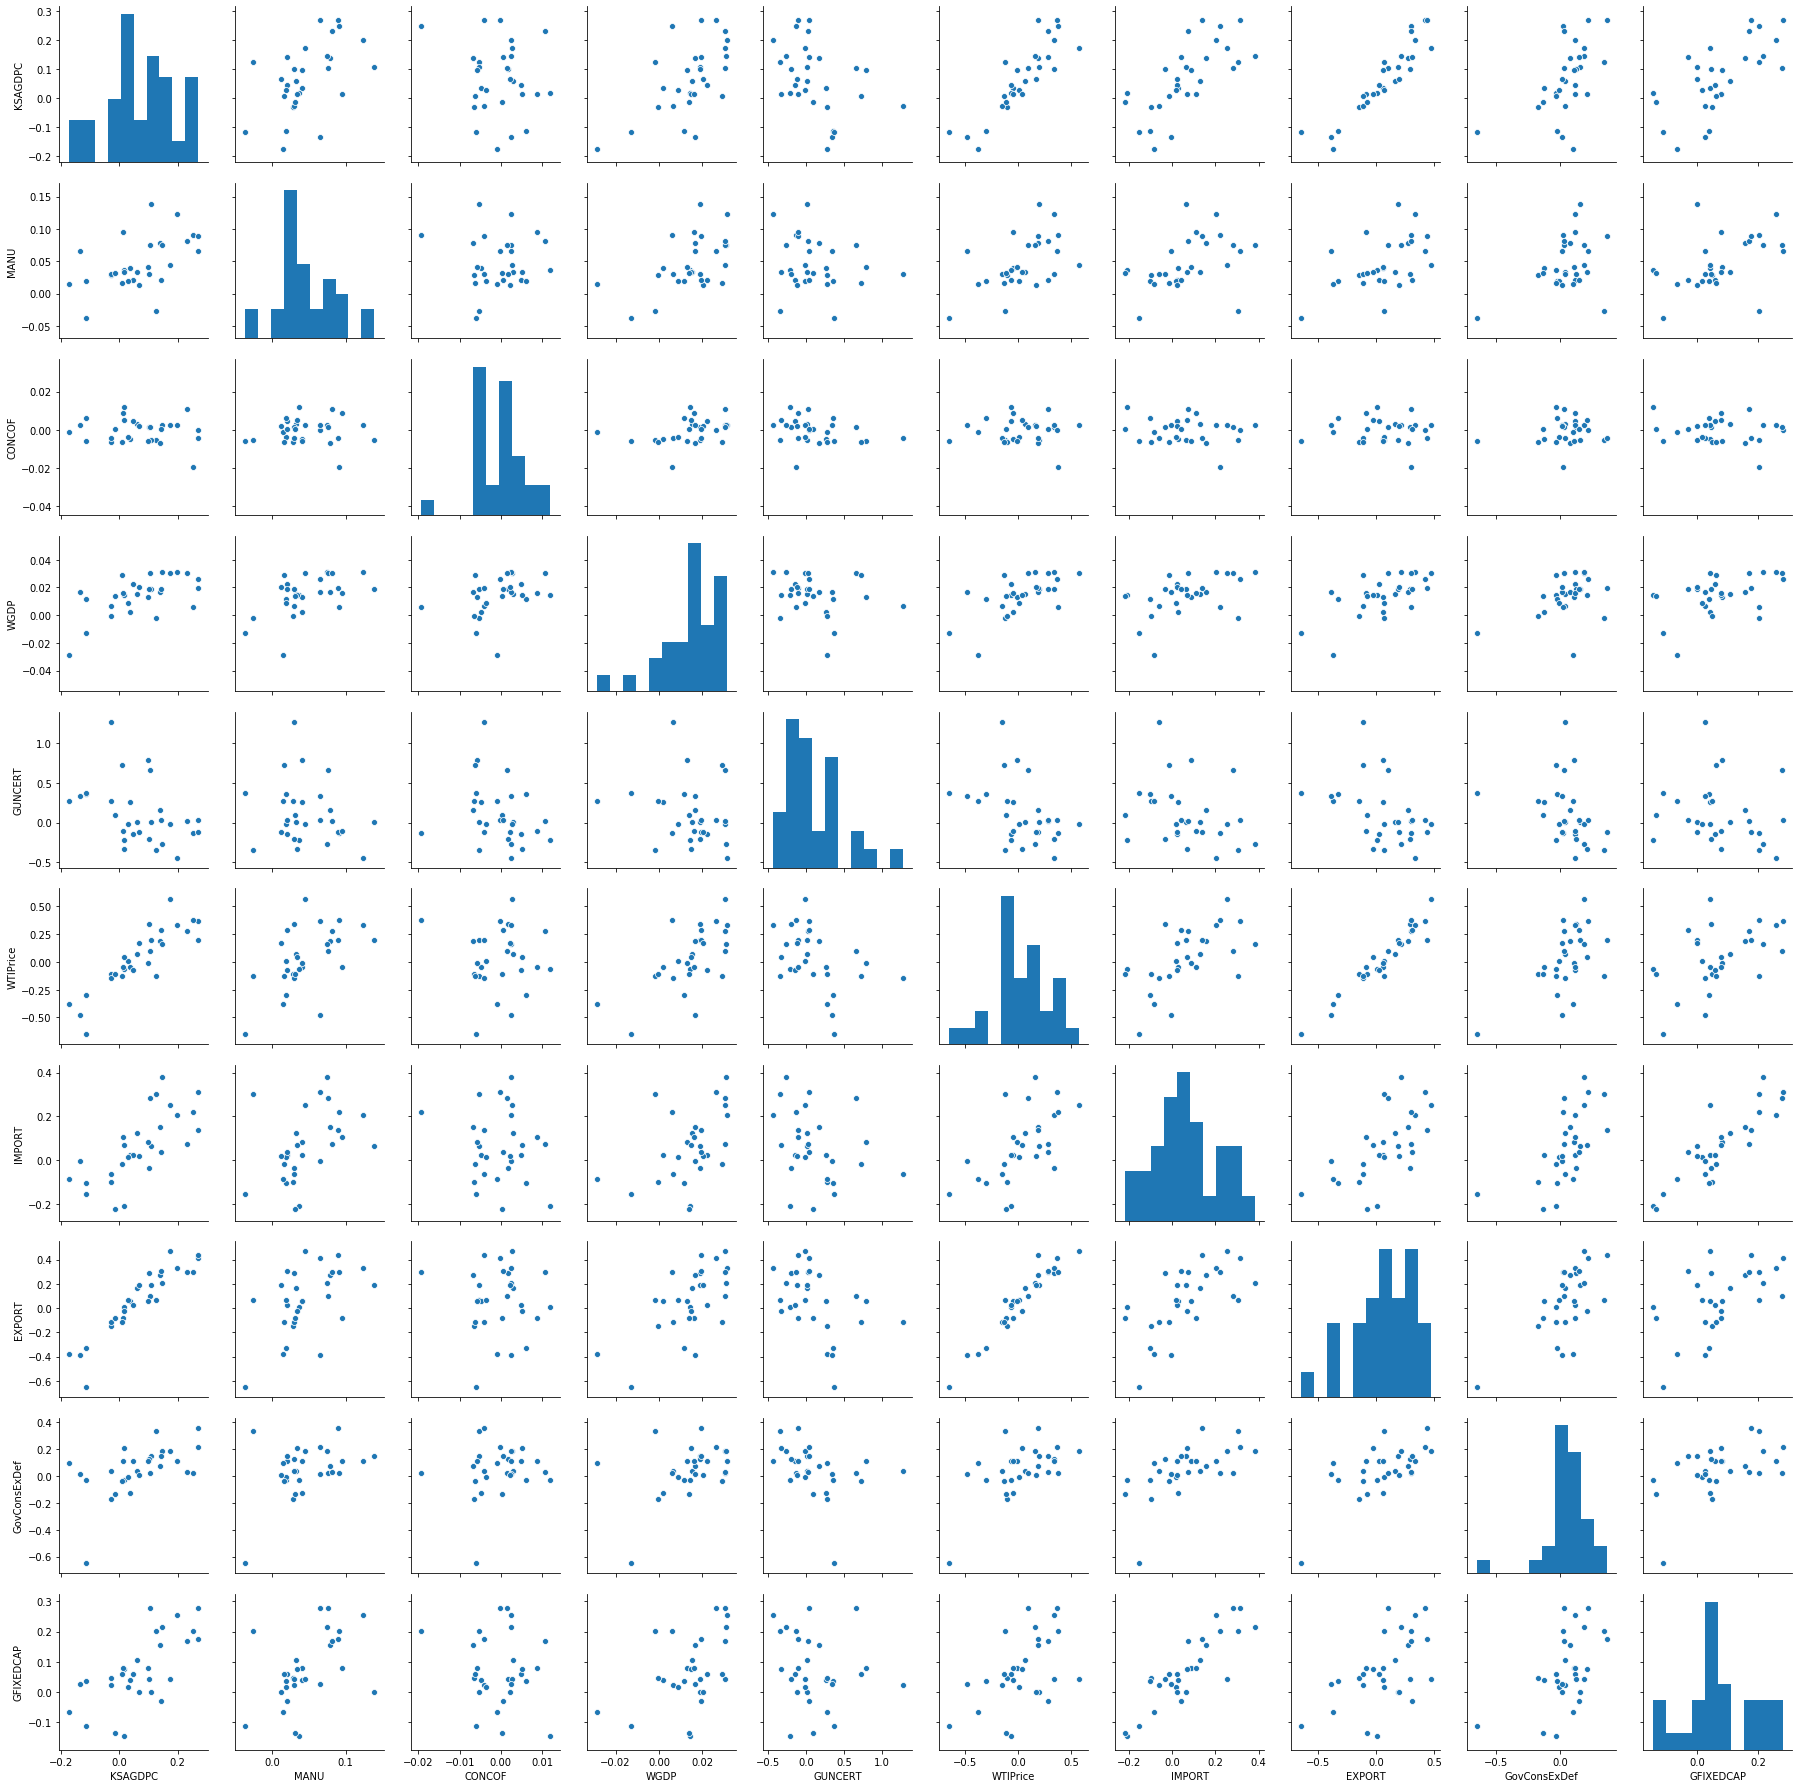

In [21]:
#Distributions and correlations on dataset5 i.e. pct change

sns.pairplot(dataset5)

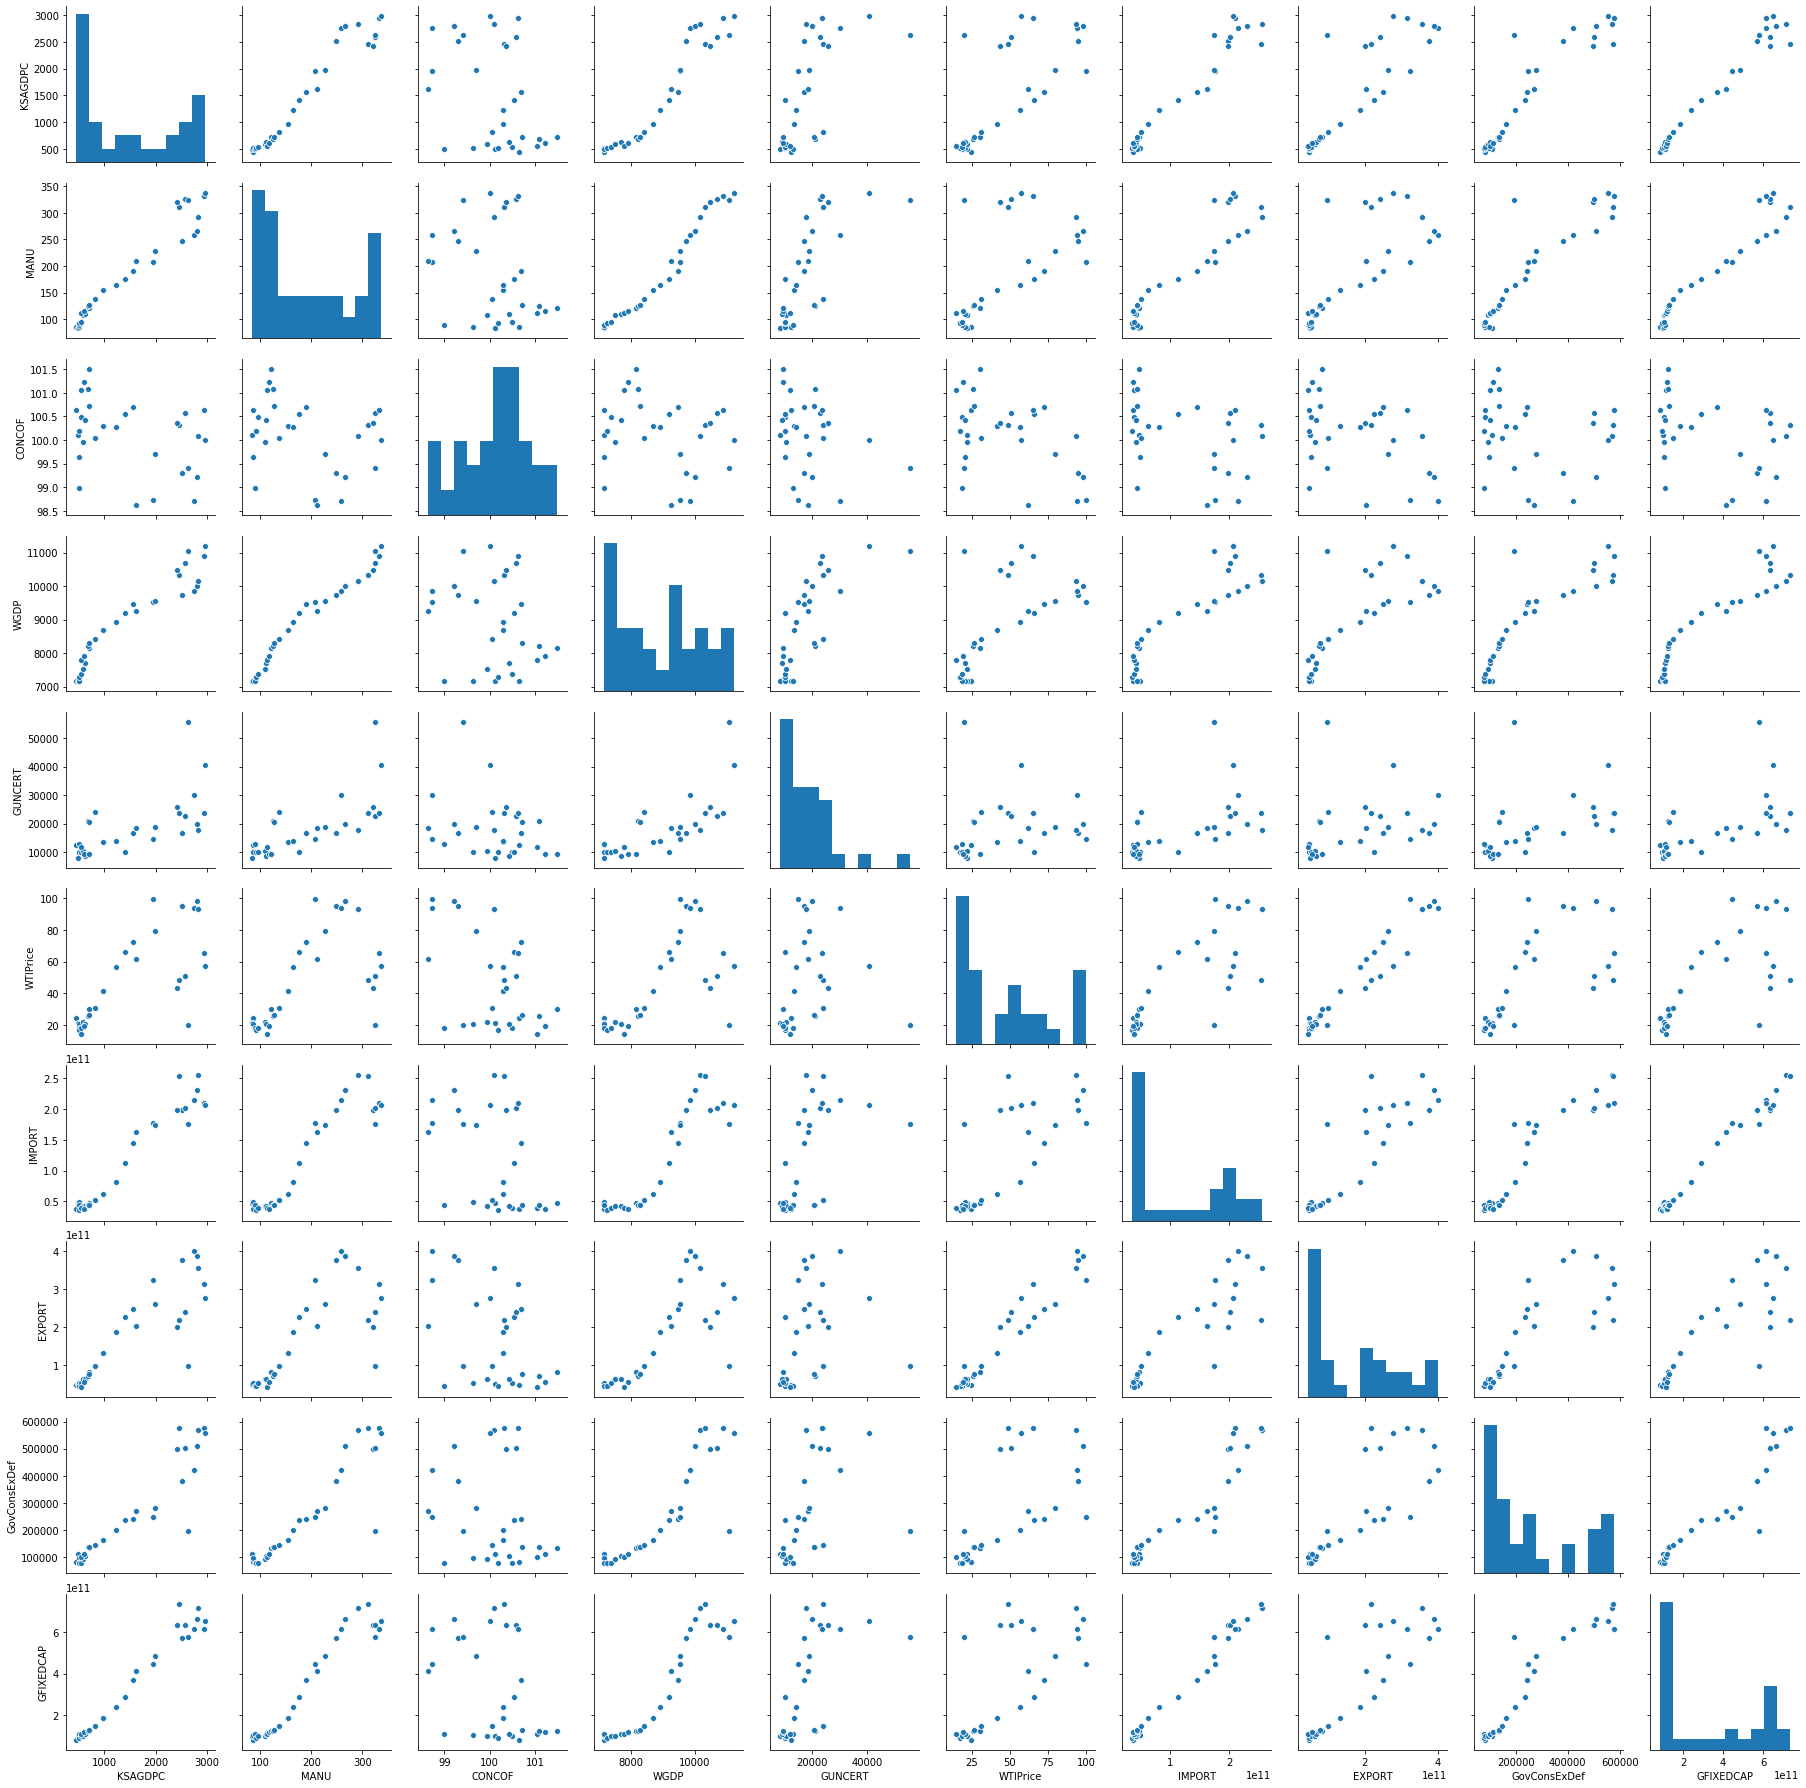

In [20]:
#Distributions and correlations on dataset5 i.e. without pct change

sns.pairplot(dataset2)

In [21]:
#dataset2 is the original dataset with dropped variables

dataset2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 10 columns):
KSAGDPC         31 non-null float64
MANU            31 non-null float64
CONCOF          31 non-null float64
WGDP            31 non-null float64
GUNCERT         31 non-null float64
WTIPrice        31 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
GovConsExDef    31 non-null float64
GFIXEDCAP       31 non-null float64
dtypes: float64(10)
memory usage: 3.9 KB


In [22]:
#further calcs were done dataset6 which have been removed from the script
dataset6 = dataset2

In [23]:
dataset6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 10 columns):
KSAGDPC         31 non-null float64
MANU            31 non-null float64
CONCOF          31 non-null float64
WGDP            31 non-null float64
GUNCERT         31 non-null float64
WTIPrice        31 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
GovConsExDef    31 non-null float64
GFIXEDCAP       31 non-null float64
dtypes: float64(10)
memory usage: 2.7 KB


In [24]:
dataset6.tail(5)

KSAGDPC       MANU      CONCOF         WGDP      GUNCERT  \
date                                                                       
2016-12-31  2418.508280  321.17000  100.355375  10473.74581  25888.22000   
2017-12-31  2582.198416  325.34000  100.581433  10685.56418  22786.65800   
2018-12-31  2949.456868  332.16000  100.627600  10891.00147  23607.30000   
2019-12-31  2973.625643  337.57000  100.007208  11206.84051  40648.57500   
2020-12-31  2628.685068  325.07991   99.407165  11061.15159  55647.89918   

            WTIPrice        IMPORT        EXPORT  GovConsExDef     GFIXEDCAP  
date                                                                          
2016-12-31     43.29  1.980000e+11  2.010000e+11    497976.000  6.320000e+11  
2017-12-31     50.80  2.020000e+11  2.400000e+11    502908.000  6.320000e+11  
2018-12-31     65.23  2.100000e+11  3.140000e+11    576996.000  6.130000e+11  
2019-12-31     56.99  2.070000e+11  2.770000e+11    556801.140  6.500000e+11  
2020-12-31     20.00  1.750000e+11  9.700873e+10    194880.399  5.770000e+11

<h2> 3. Testing for Stationarity <h/2>

We will now conduct unit root tests to check if the series is stationary

In [25]:
def adjust(val, length= 6): return str(val).ljust(length)

In [26]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [27]:
# ADF Test on each column. Augmented Dickey Fuller tests for whether the series is difference stationary.
#Late we discover that the series is difference stationary

for name, column in dataset6.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1384
 No. Lags Chosen       = 8
 Critical value 1%     = -3.77
 Critical value 5%     = -3.005
 Critical value 10%    = -2.643
 => P-Value = 0.0238. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1471
 No. Lags Chosen       = 8
 Critical value 1%     = -3.77
 Critical value 5%     = -3.005
 Critical value 10%    = -2.643
 => P-Value = 0.226. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CONCOF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


In [28]:
# 1st difference
dataset6_differenced = dataset6.diff().dropna()

In [29]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in dataset6_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0657
 No. Lags Chosen       = 9
 Critical value 1%     = -3.809
 Critical value 5%     = -3.022
 Critical value 10%    = -2.651
 => P-Value = 0.2585. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2122
 No. Lags Chosen       = 5
 Critical value 1%     = -3.738
 Critical value 5%     = -2.992
 Critical value 10%    = -2.636
 => P-Value = 0.6683. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CONCOF" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [30]:
# Second Differencing
dataset6_differenced1 = dataset6_differenced.diff().dropna()

In [31]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in dataset6_differenced1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8448
 No. Lags Chosen       = 7
 Critical value 1%     = -3.788
 Critical value 5%     = -3.013
 Critical value 10%    = -2.646
 => P-Value = 0.8056. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1095
 No. Lags Chosen       = 3
 Critical value 1%     = -3.724
 Critical value 5%     = -2.986
 Critical value 10%    = -2.633
 => P-Value = 0.7113. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CONCOF" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [32]:
# Third Differencing
dataset6_differenced2 = dataset6_differenced1.diff().dropna()

In [33]:
# ADF Test on each column of third Differences Dataframe
for name, column in dataset6_differenced2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9465
 No. Lags Chosen       = 7
 Critical value 1%     = -3.809
 Critical value 5%     = -3.022
 Critical value 10%    = -2.651
 => P-Value = 0.0017. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7633
 No. Lags Chosen       = 2
 Critical value 1%     = -3.724
 Critical value 5%     = -2.986
 Critical value 10%    = -2.633
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CONCOF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [34]:
# Fourth Differencing
dataset6_differenced3 = dataset6_differenced2.diff().dropna()

In [35]:
# ADF Test on each column of fourth Differences Dataframe
for name, column in dataset6_differenced3.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6561
 No. Lags Chosen       = 8
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.0048. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5038
 No. Lags Chosen       = 4
 Critical value 1%     = -3.77
 Critical value 5%     = -3.005
 Critical value 10%    = -2.643
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CONCOF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [36]:
# fifth Differencing
dataset6_differenced4 = dataset6_differenced3.diff().dropna()

In [37]:
# ADF Test on each column of fifth Differences Dataframe
for name, column in dataset6_differenced4.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.2443
 No. Lags Chosen       = 8
 Critical value 1%     = -3.889
 Critical value 5%     = -3.054
 Critical value 10%    = -2.667
 => P-Value = 0.0006. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.359
 No. Lags Chosen       = 4
 Critical value 1%     = -3.788
 Critical value 5%     = -3.013
 Critical value 10%    = -2.646
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CONCOF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [38]:
# sixth Differencing
dataset6_differenced5 = dataset6_differenced4.diff().dropna()

In [39]:
# ADF Test on each column of 6th Differences Dataframe
for name, column in dataset6_differenced5.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3157
 No. Lags Chosen       = 8
 Critical value 1%     = -3.924
 Critical value 5%     = -3.068
 Critical value 10%    = -2.674
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1637
 No. Lags Chosen       = 9
 Critical value 1%     = -3.964
 Critical value 5%     = -3.085
 Critical value 10%    = -2.682
 => P-Value = 0.689. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CONCOF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

Since our series is not proving to be stationary despite taking differences, we take logs and subsequently differences of logs

In [25]:
#Taking Logs on original series

#Taking logs. Added +1 in order to take care of zero values in any column. Log of zero would return an error otherwise
Ldataset6 = np.log(dataset6 + 1)

In [26]:
# ADF Test on each column
for name, column in Ldataset6.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

NameError: name 'adfuller_test' is not defined

In [27]:
#Taking differences of logs
DLdataset6 = Ldataset6.diff().dropna()

In [28]:
DLdataset6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1991-12-31 to 2020-12-31
Data columns (total 10 columns):
KSAGDPC         30 non-null float64
MANU            30 non-null float64
CONCOF          30 non-null float64
WGDP            30 non-null float64
GUNCERT         30 non-null float64
WTIPrice        30 non-null float64
IMPORT          30 non-null float64
EXPORT          30 non-null float64
GovConsExDef    30 non-null float64
GFIXEDCAP       30 non-null float64
dtypes: float64(10)
memory usage: 2.6 KB


In [29]:
DLdataset6.tail(2)

KSAGDPC      MANU    CONCOF      WGDP   GUNCERT  WTIPrice  \
date                                                                     
2019-12-31  0.008158  0.016108 -0.006123  0.028585  0.543390 -0.132863   
2020-12-31 -0.123254 -0.037588 -0.005958 -0.013084  0.314074 -1.015748   

              IMPORT    EXPORT  GovConsExDef  GFIXEDCAP  
date                                                     
2019-12-31 -0.014389 -0.125375     -0.035627   0.058607  
2020-12-31 -0.167933 -1.049217     -1.049819  -0.119130

In [30]:
# ADF Test on each column with differenced log
for name, column in DLdataset6.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

NameError: name 'adfuller_test' is not defined

In [45]:
#So taking differences of logs has now made our series stationary

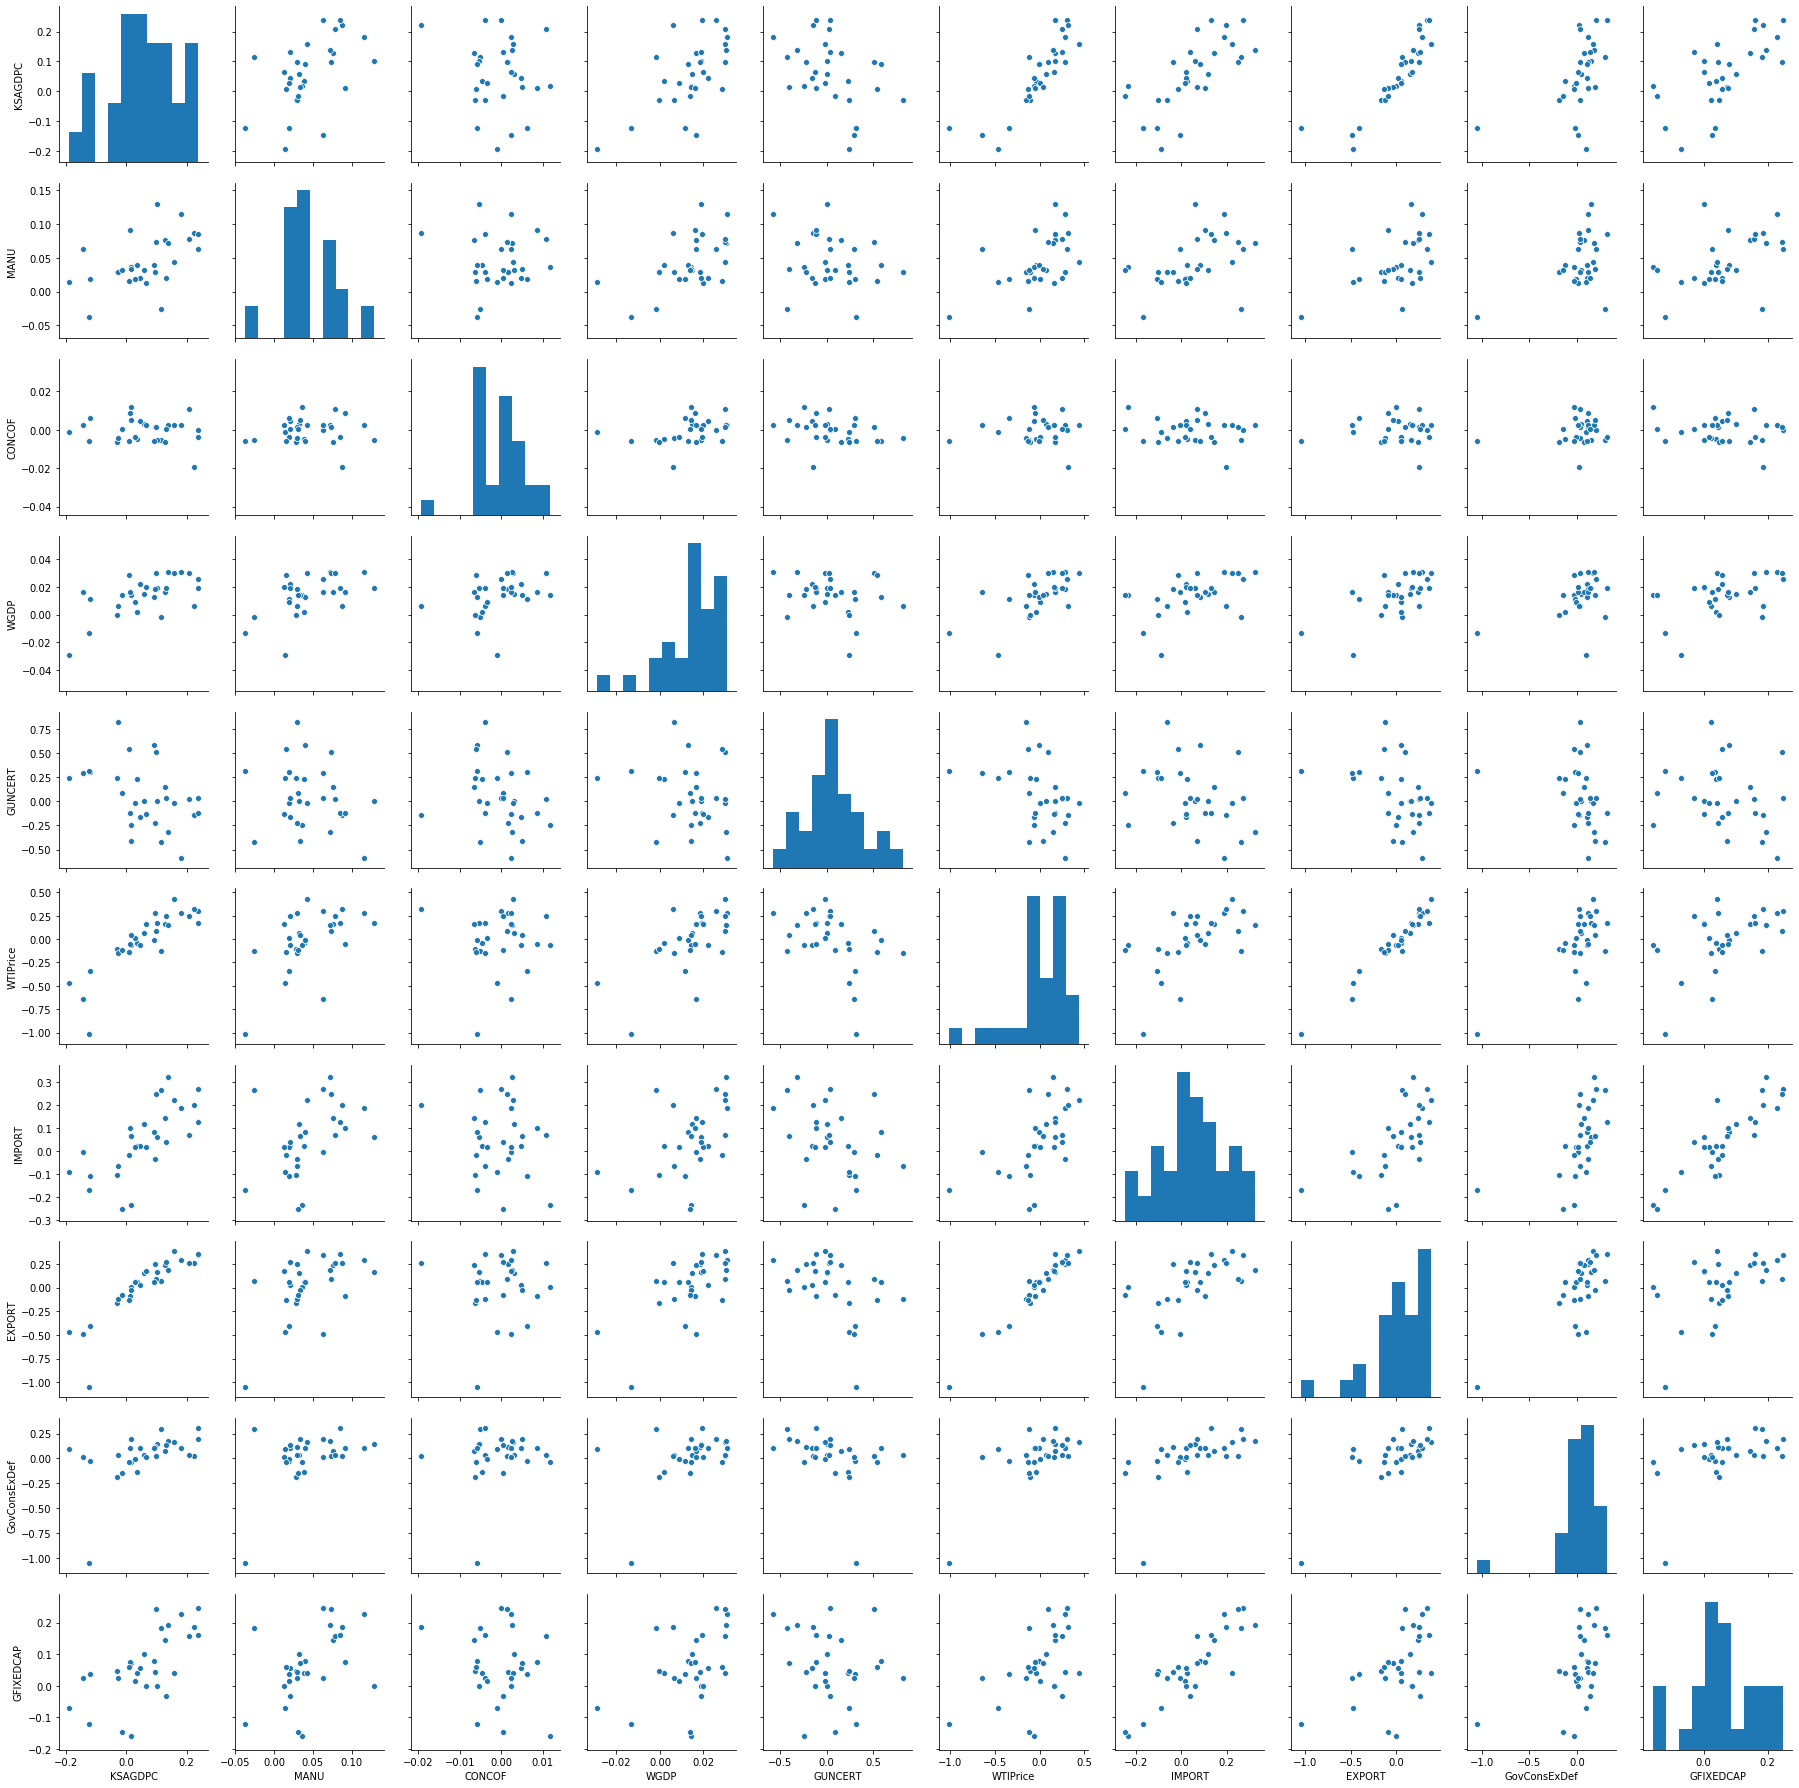

In [46]:
#Plotting the log differenced series to understand correl and distribution

sns.pairplot(DLdataset6)

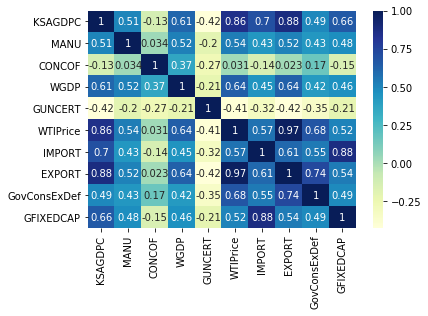

In [47]:
#Some correlation analysis to see the strength of relationships between X and Y variables and any multicollinearity

sns.heatmap(DLdataset6.corr(), cmap="YlGnBu", annot = True)

In [48]:
DLdataset6.to_csv (r'C:\Users\muanwer\.condaexport_dataframe.csv', index = False, header=True)


In [49]:
# KPSS tests whether a seires is trend stationary. We might need to insert a time trend/detrend to improve forecast results

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [50]:
kpss_test(DLdataset6)

ValueError: x of shape (30, 10) not understood

<h2> 4. Testing Causation using Granger’s Causality Test</h2> 


Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [51]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    DLdataset6 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in DLdataset6.columns:
        for r in DLdataset6.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            DLdataset6.loc[r, c] = min_p_value
    DLdataset6.columns = [var + '_x' for var in variables]
    DLdataset6.index = [var + '_y' for var in variables]
    return DLdataset6

grangers_causation_matrix(DLdataset6, variables = DLdataset6.columns)        

KSAGDPC_x  MANU_x  CONCOF_x  WGDP_x  GUNCERT_x  WTIPrice_x  \
KSAGDPC_y          1.0000  0.0363    0.0212  0.3475     0.6572      0.0420   
MANU_y             0.0000  1.0000    0.0007  0.2364     0.0149      0.0080   
CONCOF_y           0.0572  0.4277    1.0000  0.0124     0.2877      0.1409   
WGDP_y             0.4529  0.2586    0.0012  1.0000     0.0125      0.5975   
GUNCERT_y          0.0297  0.0000    0.4115  0.2214     1.0000      0.0173   
WTIPrice_y         0.0133  0.0001    0.1489  0.3957     0.6315      1.0000   
IMPORT_y           0.0753  0.0044    0.0431  0.3749     0.1301      0.0315   
EXPORT_y           0.0008  0.0005    0.0764  0.3164     0.5068      0.3786   
GovConsExDef_y     0.0003  0.0088    0.1787  0.2992     0.1358      0.0000   
GFIXEDCAP_y        0.2557  0.2164    0.0000  0.0785     0.0162      0.1562   

                IMPORT_x  EXPORT_x  GovConsExDef_x  GFIXEDCAP_x  
KSAGDPC_y         0.0313    0.0050          0.1345       0.0322  
MANU_y            0.0000    0.0009          0.0004       0.0007  
CONCOF_y          0.0373    0.0703          0.2491       0.0560  
WGDP_y            0.2000    0.7375          0.0190       0.3708  
GUNCERT_y         0.2993    0.0162          0.0745       0.3532  
WTIPrice_y        0.4332    0.4941          0.0891       0.6570  
IMPORT_y          1.0000    0.0036          0.0847       0.0597  
EXPORT_y          0.0967    1.0000          0.1602       0.3683  
GovConsExDef_y    0.5091    0.0024          1.0000       0.4648  
GFIXEDCAP_y       0.3190    0.1085          0.0354       1.0000

In [52]:
#Variables seem to have specific intermixed relationships as the pvalues are significant and insignificant for all variable
#depending on the variable they are mapped agianst, in the matrix above

<h2> 5. Cointegration Test <h/2>

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship. This is the basic premise on which Vector Autoregression(VAR) models is based on.

In [53]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(DLdataset6, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(DLdataset6,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataset6.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(DLdataset6)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
KSAGDPC ::  318.25    > 219.4051  =>   True
MANU   ::  234.76    > 179.5199  =>   True
CONCOF ::  167.69    > 143.6691  =>   True
WGDP   ::  117.63    > 111.7797  =>   True
GUNCERT ::  74.54     > 83.9383   =>   False
WTIPrice ::  44.32     > 60.0627   =>   False
IMPORT ::  25.98     > 40.1749   =>   False
EXPORT ::  11.92     > 24.2761   =>   False
GovConsExDef ::  4.88      > 12.3212   =>   False
GFIXEDCAP ::  0.0       > 4.1296    =>   False


<h2> 6. Split series into training and test <h/2>


In [213]:
nobs = 1
DLdataset6_train, DLdataset6_test = DLdataset6[0:-nobs], DLdataset6[-nobs:]

# Check size
print(DLdataset6_train.shape)
print(DLdataset6_test.shape)

(29, 10)
(1, 10)


<h2> 7. Select the Order of VAR <h/2>


To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [214]:
#our VAR is going back only as far as one lag due to the limitation of number of rows

model = VAR(DLdataset6_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -60.49562533290591
BIC :  -55.261964757217605
FPE :  8.335406968994112e-27
HQIC:  -58.89564311842635 

Lag Order = 2


C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


LinAlgError: 7-th leading minor of the array is not positive definite

In [215]:
#An alternate way to choose the order of VAR is given below. Since we do not have much data (rows) we keep the max lags to 1
x = model.select_order(maxlags=1)
x.summary()

#Bias Variance tradeoff in mind with AIC and SBC

<class 'statsmodels.iolib.table.SimpleTable'>

<h2> 8. Train the VAR Model of Selected Order <h/2>

In [216]:
model_fitted = model.fit(4)
model_fitted.summary()

C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1374: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self._cov_params()))
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, May, 2020
Time:                     10:38:18
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -675.431
Nobs:                     25.0000    HQIC:                  -689.877
Log likelihood:           8748.02    FPE:               7.79792e-311
AIC:                     -695.421    Det(Omega_mle):    4.74176e-315
--------------------------------------------------------------------
Results for equation KSAGDPC
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.220597         0.000000     35422126.988           0.000
L1.KSAGDPC             -1.381954              NAN              NAN             NAN
L1.MANU                 0.344402         0.000000 

<h2>  9. Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic <h/2>


In [217]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
for col, val in zip(DLdataset6.columns, out):
    print(adjust(col), ':', round(val, 2))

KSAGDPC : 2.92
MANU   : 1.39
CONCOF : 0.81
WGDP   : 1.99
GUNCERT : 1.59
WTIPrice : 2.31
IMPORT : 2.1
EXPORT : 1.76
GovConsExDef : 2.28
GFIXEDCAP : 1.77


<h2>  10. Forecast VAR model <h/2>


In [218]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = DLdataset6.values[-lag_order:]
forecast_input

4


array([[ 6.54639978e-02,  1.28604261e-02,  2.22786980e-03,
         2.00200692e-02, -1.27607592e-01,  1.56631231e-01,
         2.00006667e-02,  1.77334015e-01,  9.85534800e-03,
         0.00000000e+00],
       [ 1.32931702e-01,  2.06830724e-02,  4.54376462e-04,
         1.90414414e-02,  3.53792715e-02,  2.45743383e-01,
         3.88398333e-02,  2.68754063e-01,  1.37427828e-01,
        -3.05244582e-02],
       [ 8.15816793e-03,  1.61080106e-02, -6.12326820e-03,
         2.85848691e-02,  5.43390036e-01, -1.32862951e-01,
        -1.43887375e-02, -1.25375480e-01, -3.56271148e-02,
         5.86074270e-02],
       [-1.23254104e-01, -3.75883916e-02, -5.95831385e-03,
        -1.30840638e-02,  3.14073916e-01, -1.01574814e+00,
        -1.67932819e-01, -1.04921653e+00, -1.04981879e+00,
        -1.19130096e-01]])

In [219]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
DLdataset6_forecast = pd.DataFrame(fc, index=DLdataset6.index[-nobs:], columns=DLdataset6.columns + '_forecast')
DLdataset6_forecast

KSAGDPC_forecast  MANU_forecast  CONCOF_forecast  WGDP_forecast  \
date                                                                          
2020-12-31         -0.288904       0.011635         -0.01349      -0.061323   

            GUNCERT_forecast  WTIPrice_forecast  IMPORT_forecast  \
date                                                               
2020-12-31         -1.059189          -0.302299        -0.672738   

            EXPORT_forecast  GovConsExDef_forecast  GFIXEDCAP_forecast  
date                                                                    
2020-12-31        -0.524645              -0.274443           -0.262735

<h2>  11. Plot of forecast vs. actuals <h/2>  

In [220]:
DLdataset6_test

KSAGDPC      MANU    CONCOF      WGDP   GUNCERT  WTIPrice  \
date                                                                     
2020-12-31 -0.123254 -0.037588 -0.005958 -0.013084  0.314074 -1.015748   

              IMPORT    EXPORT  GovConsExDef  GFIXEDCAP  
date                                                     
2020-12-31 -0.167933 -1.049217     -1.049819   -0.11913

In [221]:
DLdataset6_forecast

KSAGDPC_forecast  MANU_forecast  CONCOF_forecast  WGDP_forecast  \
date                                                                          
2020-12-31         -0.288904       0.011635         -0.01349      -0.061323   

            GUNCERT_forecast  WTIPrice_forecast  IMPORT_forecast  \
date                                                               
2020-12-31         -1.059189          -0.302299        -0.672738   

            EXPORT_forecast  GovConsExDef_forecast  GFIXEDCAP_forecast  
date                                                                    
2020-12-31        -0.524645              -0.274443           -0.262735

In [31]:
DLdataset6

KSAGDPC      MANU    CONCOF      WGDP   GUNCERT  WTIPrice  \
date                                                                     
1991-12-31  0.116696 -0.026131 -0.005213 -0.001824 -0.425750 -0.124563   
1992-12-31  0.036059  0.038945 -0.004714  0.001921  0.234187 -0.043525   
1993-12-31 -0.030454  0.028496 -0.006391 -0.000418  0.241105 -0.104949   
1994-12-31  0.016429  0.036129  0.011856  0.014368 -0.246475 -0.065397   
1995-12-31  0.058559  0.032374  0.002971  0.014948  0.004965  0.065397   
1996-12-31  0.101359  0.129032 -0.005293  0.018803  0.004668  0.173880   
1997-12-31  0.044916  0.020199  0.004742  0.021993 -0.158785 -0.067542   
1998-12-31 -0.121322  0.018920  0.006098  0.011391  0.303786 -0.337491   
1999-12-31  0.096776  0.029136  0.001661  0.018493 -0.225815  0.276924   
2000-12-31  0.158379  0.042990  0.002697  0.029759 -0.016929  0.433581   
2001-12-31 -0.028744  0.029364 -0.004057  0.006413  0.818423 -0.151075   
2002-12-31  0.029224  0.018900 -0.003520  0.008846 -0.019238  0.007386   
2003-12-31  0.129269  0.075478 -0.006606  0.016600  0.152709  0.165751   
2004-12-31  0.181240  0.115208  0.002420  0.030617 -0.582164  0.281507   
2005-12-31  0.237590  0.063018 -0.000124  0.026004  0.037751  0.304477   
2006-12-31  0.136902  0.072148  0.002555  0.030496 -0.315023  0.151222   
2007-12-31  0.099220  0.072751  0.001481  0.029997  0.506428  0.089668   
2008-12-31  0.223376  0.086959 -0.019464  0.006014 -0.143694  0.316742   
2009-12-31 -0.191644  0.014677 -0.001043 -0.029093  0.238242 -0.469507   
2010-12-31  0.207687  0.077828  0.010663  0.030121  0.019885  0.245668   
2011-12-31  0.239529  0.084949 -0.003977  0.019206 -0.119557  0.175089   
2012-12-31  0.092036  0.039720 -0.005818  0.012988  0.581333 -0.008694   
2013-12-31  0.014392  0.033020  0.005007  0.014417 -0.406650  0.040515   
2014-12-31  0.012907  0.090801  0.008624  0.016195 -0.118220 -0.049816   
2015-12-31 -0.144930  0.063606  0.002336  0.016545  0.289942 -0.639902   
2016-12-31 -0.014364  0.031403  0.000338  0.013923  0.086230 -0.114441   
2017-12-31  0.065464  0.012860  0.002228  0.020020 -0.127608  0.156631   
2018-12-31  0.132932  0.020683  0.000454  0.019041  0.035379  0.245743   
2019-12-31  0.008158  0.016108 -0.006123  0.028585  0.543390 -0.132863   
2020-12-31 -0.123254 -0.037588 -0.005958 -0.013084  0.314074 -1.015748   

              IMPORT    EXPORT  GovConsExDef  GFIXEDCAP  
date                                                     
1991-12-31  0.265309  0.065400      0.290299   0.183314  
1992-12-31  0.024920  0.056758     -0.132059   0.039221  
1993-12-31 -0.103446 -0.160126     -0.189790   0.046957  
1994-12-31 -0.232916  0.006166     -0.033577  -0.158725  
1995-12-31  0.119445  0.152291      0.036396   0.102106  
1996-12-31  0.062041  0.170980      0.141763   0.000000  
1997-12-31  0.022143  0.023160      0.104102   0.056619  
1998-12-31 -0.106611 -0.401617     -0.027102   0.036040  
1999-12-31 -0.035267  0.253850      0.117195   0.043297  
2000-12-31  0.224625  0.383427      0.169380   0.041500  
2001-12-31 -0.063059 -0.119686      0.033791   0.024098  
2002-12-31  0.017370  0.061907     -0.008312   0.015748  
2003-12-31  0.143427  0.242583      0.074510   0.145182  
2004-12-31  0.186456  0.288119      0.108369   0.228534  
2005-12-31  0.271475  0.348307      0.197259   0.246524  
2006-12-31  0.323142  0.189426      0.171504   0.194156  
2007-12-31  0.249346  0.096918      0.025338   0.244370  
2008-12-31  0.199416  0.260199      0.022136   0.185028  
2009-12-31 -0.088553 -0.469385      0.092751  -0.069959  
2010-12-31  0.071459  0.260077      0.031108   0.156219  
2011-12-31  0.129212  0.361245      0.306935   0.161796  
2012-12-31  0.082371  0.059372      0.103707   0.077742  
2013-12-31  0.067441 -0.027956      0.190123   0.073643  
2014-12-31  0.103184 -0.088888      0.109199   0.075617  
2015-12-31 -0.003929 -0.487623      0.012376   0.024898  
2016-12-31 -0.249067 -0.081190     -0.146430  -0.146891  
2017-12-31  0.020001

C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempting to set identical left == right == 737790.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


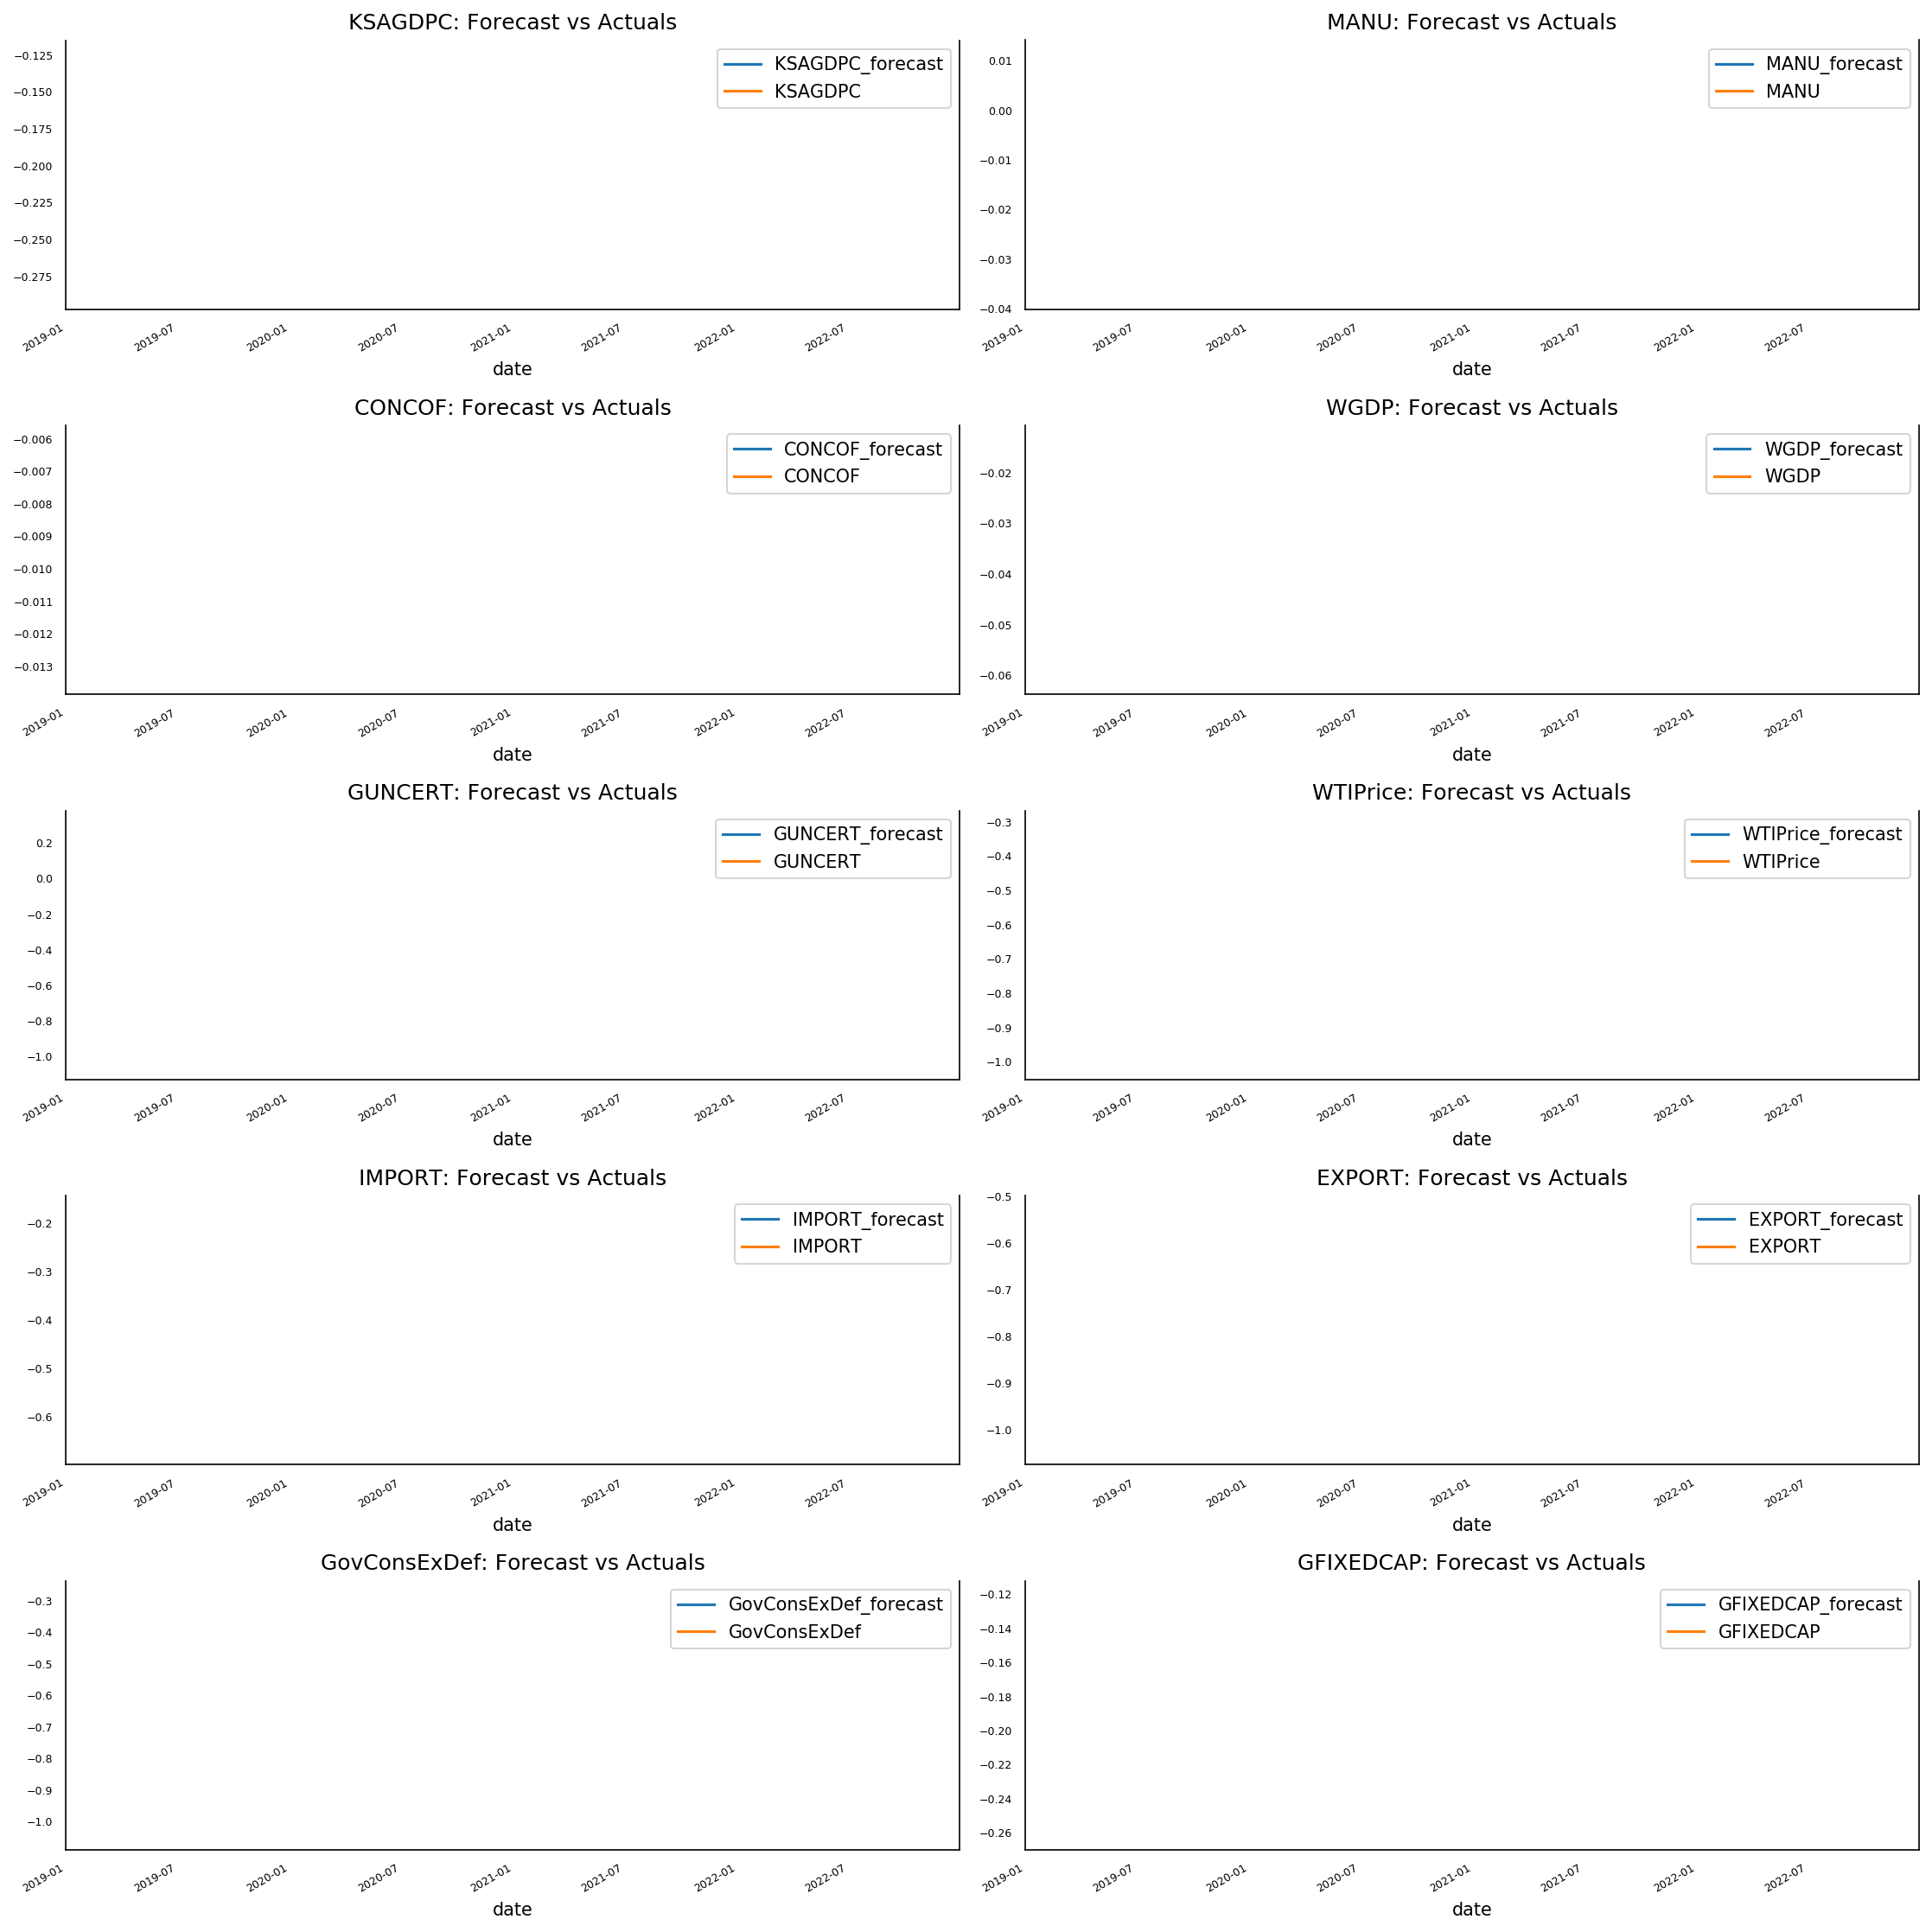

In [222]:
#Plot the forecasted values vs. the test values

fig, axes = plt.subplots(nrows=int(len(DLdataset6.columns)/2), ncols=2, dpi=150, figsize=(15,15))
for i, (col,ax) in enumerate(zip(DLdataset6.columns, axes.flatten())):
    DLdataset6_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    DLdataset6_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [223]:
#error calc

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: KGDPC')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['KSAGDPC_forecast'].values, DLdataset6_test['KSAGDPC'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: MANU')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['MANU_forecast'].values, DLdataset6_test['MANU'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: CONCOF')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['CONCOF_forecast'].values, DLdataset6_test['CONCOF'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: WGDP')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['WGDP_forecast'].values, DLdataset6_test['WGDP'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: GUNCERT')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['GUNCERT_forecast'].values, DLdataset6_test['GUNCERT'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: WTIPrice')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['WTIPrice_forecast'].values, DLdataset6_test['WTIPrice'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: IMPORT')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['IMPORT_forecast'].values, DLdataset6_test['IMPORT'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: EXPORT')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['EXPORT_forecast'].values, DLdataset6_test['EXPORT'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: KGDPC
mape   :  1.344
me     :  -0.1656
mae    :  0.1656
mpe    :  1.344
rmse   :  0.1656
corr   :  nan
minmax :  -1.344

Forecast Accuracy of: MANU
mape   :  1.3095
me     :  0.0492
mae    :  0.0492
mpe    :  -1.3095
rmse   :  0.0492
corr   :  nan
minmax :  4.2307

Forecast Accuracy of: CONCOF
mape   :  1.2641
me     :  -0.0075
mae    :  0.0075
mpe    :  1.2641
rmse   :  0.0075
corr   :  nan
minmax :  -1.2641

Forecast Accuracy of: WGDP
mape   :  3.6868
me     :  -0.0482
mae    :  0.0482
mpe    :  3.6868
rmse   :  0.0482
corr   :  nan
minmax :  -3.6868

Forecast Accuracy of: GUNCERT
mape   :  4.3724
me     :  -1.3733
mae    :  1.3733
mpe    :  -4.3724
rmse   :  1.3733
corr   :  nan
minmax :  4.3724

Forecast Accuracy of: WTIPrice
mape   :  0.7024
me     :  0.7134
mae    :  0.7134
mpe    :  -0.7024
rmse   :  0.7134
corr   :  nan
minmax :  -2.3601

Forecast Accuracy of: IMPORT
mape   :  3.006
me     :  -0.5048
mae    :  0.5048
mpe    :  3.006
rmse   :  0.5048
corr 

C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [224]:
model_fitted.irf_resim(orth=False, repl=1000, seed=None, burn=100, cum=False)


array([[[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

        [[-1.69309837e+00,  3.09041112e-01,  2.88820468e-01, ...,
           3.63276657e-01,  4.86191233e-01,  1.19131611e+00],
         [-1.28507985e-01, -2.35116851e-02,  2.87881404e-02, ...,
           1.12800962e

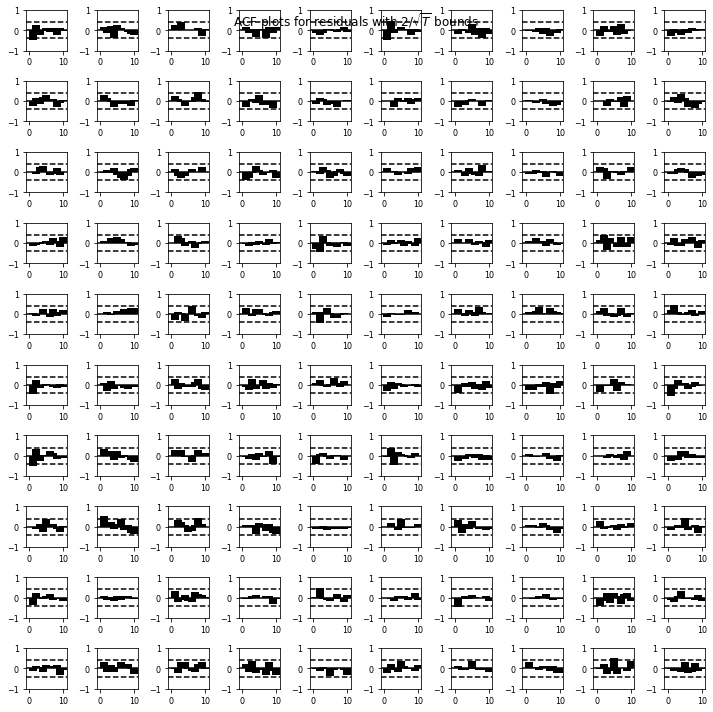

In [225]:
model_fitted.plot_acorr()
plt.tight_layout();

In [226]:
lag_order = model_fitted.k_ar
# forecast 2 periods forward based on data until 2019
ForwardForecast = model_fitted.forecast(DLdataset6.values[-lag_order:],2)
ForwardForecast

array([[-0.28890403,  0.01163465, -0.0134904 , -0.06132269, -1.05918852,
        -0.30229862, -0.67273768, -0.52464536, -0.27444276, -0.26273457],
       [ 0.19972917,  0.25289671,  0.0265027 ,  0.06711465, -1.85696387,
         0.96297133,  0.79735723,  0.80620739,  0.00216716, -0.28994045]])

In [ ]:
#For 2021, VAR is assuming that govt spending would return as strongly as it did in the past.
#Also assuming that oil prices and prod would return without considering supply glut
#Does not price in long term impact of social distancing on restaurants and religious tourism industry. 
#Hence it is showing a V shaped recovery which is not right. 19.97% increase in 2021
#Need to add dummy variables or other variables to account for this. But we have few rows and 10 equations already.
#Lucky have it fitted at 1st log difference because if we had to difference more, then many rows would have been lost

In [227]:
type(ForwardForecast)
#Plot this array above

numpy.ndarray

NameError: name 'years' is not defined

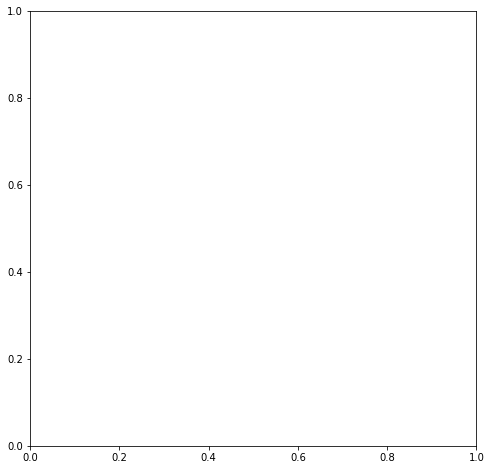

In [228]:
# set plot size for all plots that follow
plt.rcParams["figure.figsize"] = (8, 8)

# create the plot space upon which to plot the data
fig, ax = plt.subplots()
# add the x-axis and the y-axis to the plot
ax.bar(years, Pct_Change, color="grey")

# set plot title
ax.set(title="Covid19 Impact, CO")

# add labels to the axes
ax.set(xlabel="Year", ylabel="Percent Change");

C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1100: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self._forecast_vars(steps))


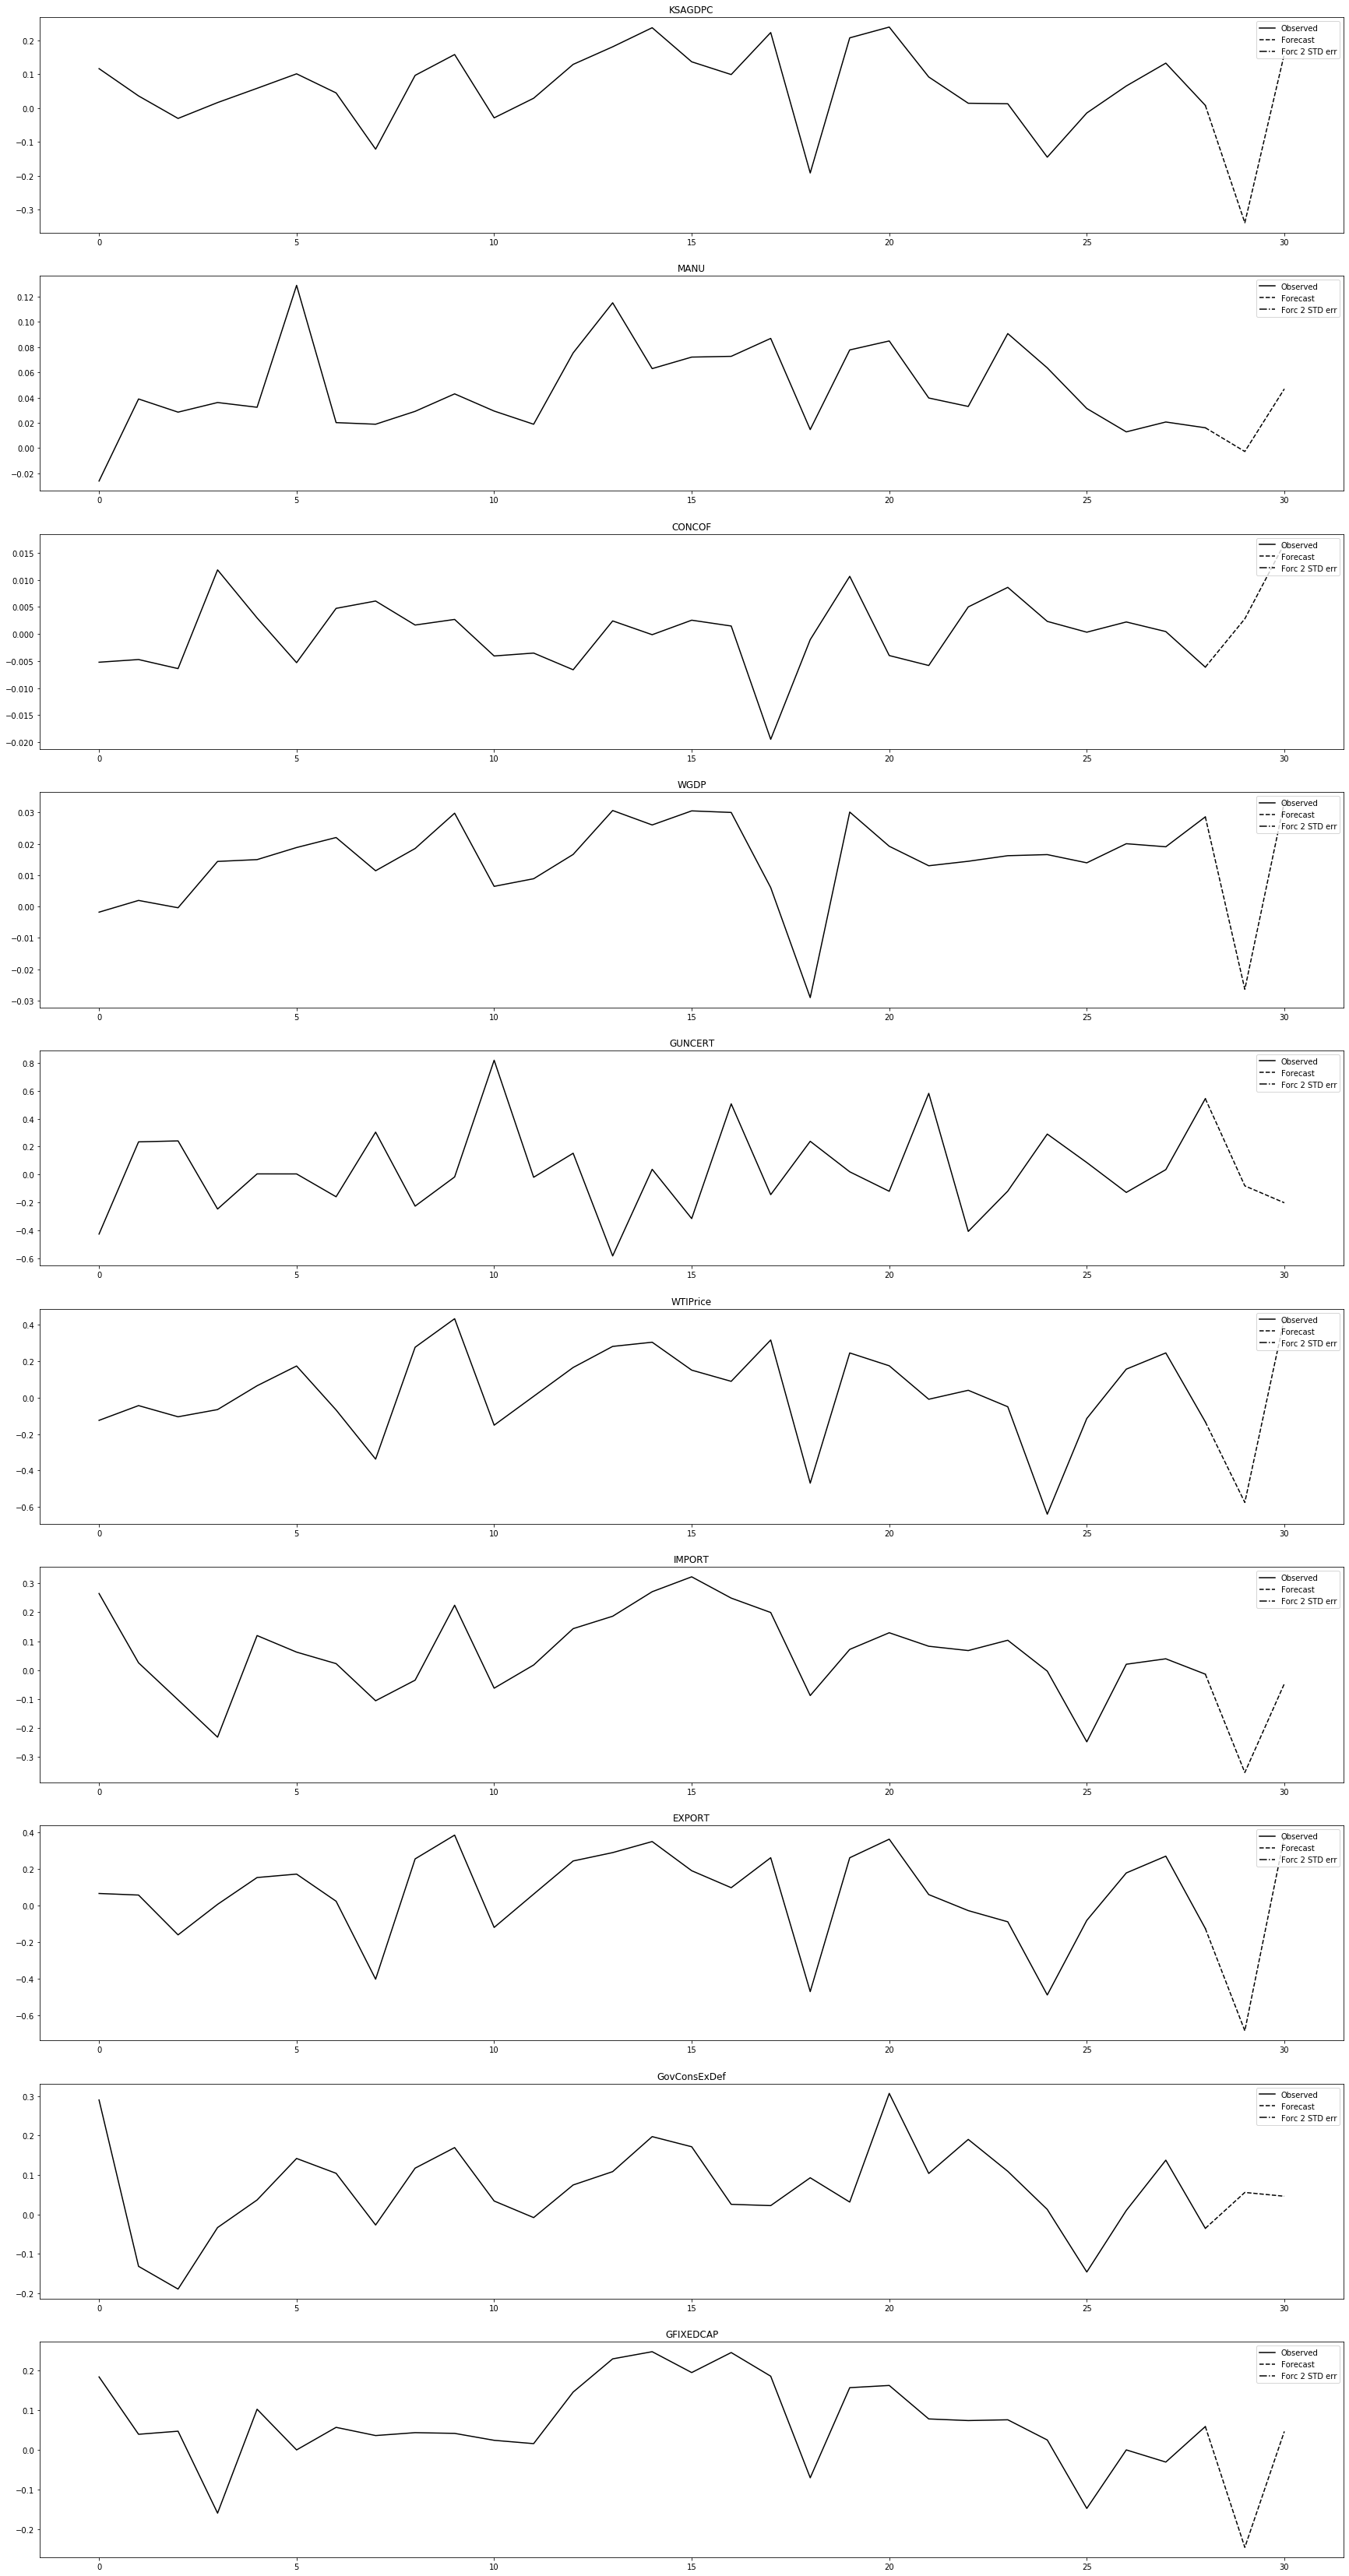

In [234]:
#GDP drop in 2020 only to recover after in 2021 - the V shaped recovery
plot_forecast = model_fitted.plot_forecast(2)
plot_forecast.set_figheight(60)
plot_forecast.set_figwidth(30)
plot_forecast.savefig('test.png', dpi = 80)


([<matplotlib.axis.XTick at 0x17cb3c4c390>,
 <a list of 2 Text xticklabel objects>)

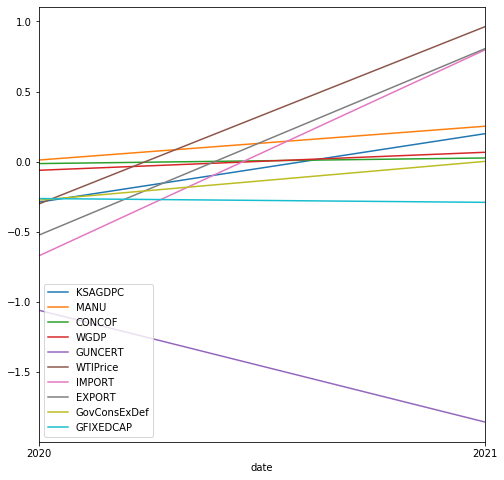

In [232]:
#Plot of 2021 forecast V shaped recovery

plot_array = model_fitted.forecast(DLdataset6.values[-lag_order:],2)
plot_array = pd.DataFrame(plot_array)
plot_array = plot_array.rename(columns = dict(enumerate(DLdataset6.columns)))
plot_array['date'] = ['2020','2021']
plot_array.set_index('date', inplace = True)
plot_array.plot()
plt.xticks(np.arange(len(plot_array.index)), plot_array.index)

In [231]:
#Original variables changed to Log differencing

DLdataset6.describe()


KSAGDPC       MANU     CONCOF       WGDP    GUNCERT   WTIPrice  \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean    0.059479   0.044399  -0.000406   0.014443   0.050220  -0.006511   
std     0.112272   0.037258   0.006286   0.013428   0.318945   0.303721   
min    -0.191644  -0.037588  -0.019464  -0.029093  -0.582164  -1.015748   
25%     0.009345   0.020320  -0.005088   0.009482  -0.139672  -0.112068   
50%     0.062011   0.034575   0.000396   0.016370   0.012425   0.023950   
75%     0.132016   0.072600   0.002662   0.021500   0.240389   0.174786   
max     0.239529   0.129032   0.011856   0.030617   0.818423   0.433581   

          IMPORT     EXPORT  GovConsExDef  GFIXEDCAP  
count  30.000000  30.000000     30.000000  30.000000  
mean    0.051882   0.023840      0.028760   0.064533  
std     0.146281   0.306900      0.233711   0.107656  
min    -0.249067  -1.049217     -1.049819  -0.158725  
25%    -0.030048  -0.086963     -0.003770   0.017836  
50%     0.050441   0.063654      0.055453   0.051788  
75%     0.139873   0.251033      0.132370   0.153460  
max     0.323142   0.383427      0.306935   0.246524

In [73]:
#Original variables changed to %
dataset4.describe()


KSAGDPC       MANU     CONCOF       WGDP    GUNCERT   WTIPrice  \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean    0.067755   0.046413  -0.000390   0.014637   0.106283   0.034769   
std     0.117674   0.039391   0.006337   0.013511   0.377940   0.269912   
min    -0.174489  -0.037000  -0.019468  -0.028677  -0.441331  -0.649061   
25%     0.009395   0.020685  -0.005126   0.009529  -0.130343  -0.108886   
50%     0.064054   0.035453   0.000400   0.016506   0.012531   0.024742   
75%     0.141218   0.075735   0.002692   0.021736   0.271770   0.198603   
max     0.270787   0.139175   0.012047   0.031094   1.267058   0.570838   

          IMPORT     EXPORT  GovConsExDef  GFIXEDCAP  
count  30.000000  30.000000     30.000000  30.000000  
mean    0.064111   0.064825      0.051005   0.072610  
std     0.154251   0.265903      0.180558   0.114473  
min    -0.220472  -0.649788     -0.650000  -0.146769  
25%    -0.029561  -0.083284     -0.003732   0.018002  
50%     0.051805   0.065725      0.057212   0.053165  
75%     0.150150   0.285368      0.141574   0.165874  
max     0.381462   0.467305      0.359254   0.279570

In [74]:
TwoSD = (np.std(DLdataset6)*2) + np.mean(DLdataset6)
print (TwoSD)

KSAGDPC         0.280250
MANU            0.117664
CONCOF          0.011956
WGDP            0.040847
GUNCERT         0.677387
WTIPrice        0.590722
IMPORT          0.339527
EXPORT          0.627324
GovConsExDef    0.488325
GFIXEDCAP       0.276227
dtype: float64


In [75]:
ThreeSD = (np.std(DLdataset6)*3) + np.mean(DLdataset6)
print (ThreeSD)

KSAGDPC         0.390635
MANU            0.154296
CONCOF          0.018136
WGDP            0.054049
GUNCERT         0.990971
WTIPrice        0.889339
IMPORT          0.483350
EXPORT          0.929065
GovConsExDef    0.718108
GFIXEDCAP       0.382074
dtype: float64


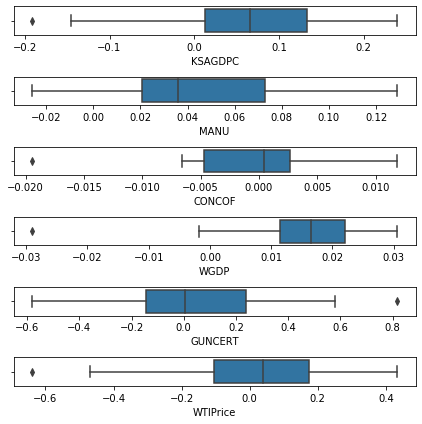

In [76]:
#Outlier analysis

fig, axs = plt.subplots(6, figsize = (6,6))
plt1 = sns.boxplot(DLdataset6_train['KSAGDPC'], ax = axs[0])
plt2 = sns.boxplot(DLdataset6_train['MANU'], ax = axs[1])
plt3 = sns.boxplot(DLdataset6_train['CONCOF'], ax = axs[2])
plt4 = sns.boxplot(DLdataset6_train['WGDP'], ax = axs[3])
plt5 = sns.boxplot(DLdataset6_train['GUNCERT'], ax = axs[4])
plt6 = sns.boxplot(DLdataset6_train['WTIPrice'], ax = axs[5])



plt.tight_layout()


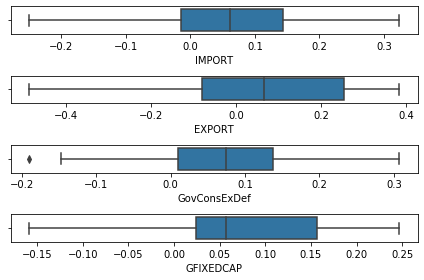

In [77]:
#Outlier analysis

fig, axs = plt.subplots(4, figsize = (6,4))

plt7 = sns.boxplot(DLdataset6_train['IMPORT'], ax = axs[0])
plt8 = sns.boxplot(DLdataset6_train['EXPORT'], ax = axs[1])
plt9 = sns.boxplot(DLdataset6_train['GovConsExDef'], ax = axs[2])
plt10 = sns.boxplot(DLdataset6_train['GFIXEDCAP'], ax = axs[3])



plt.tight_layout()

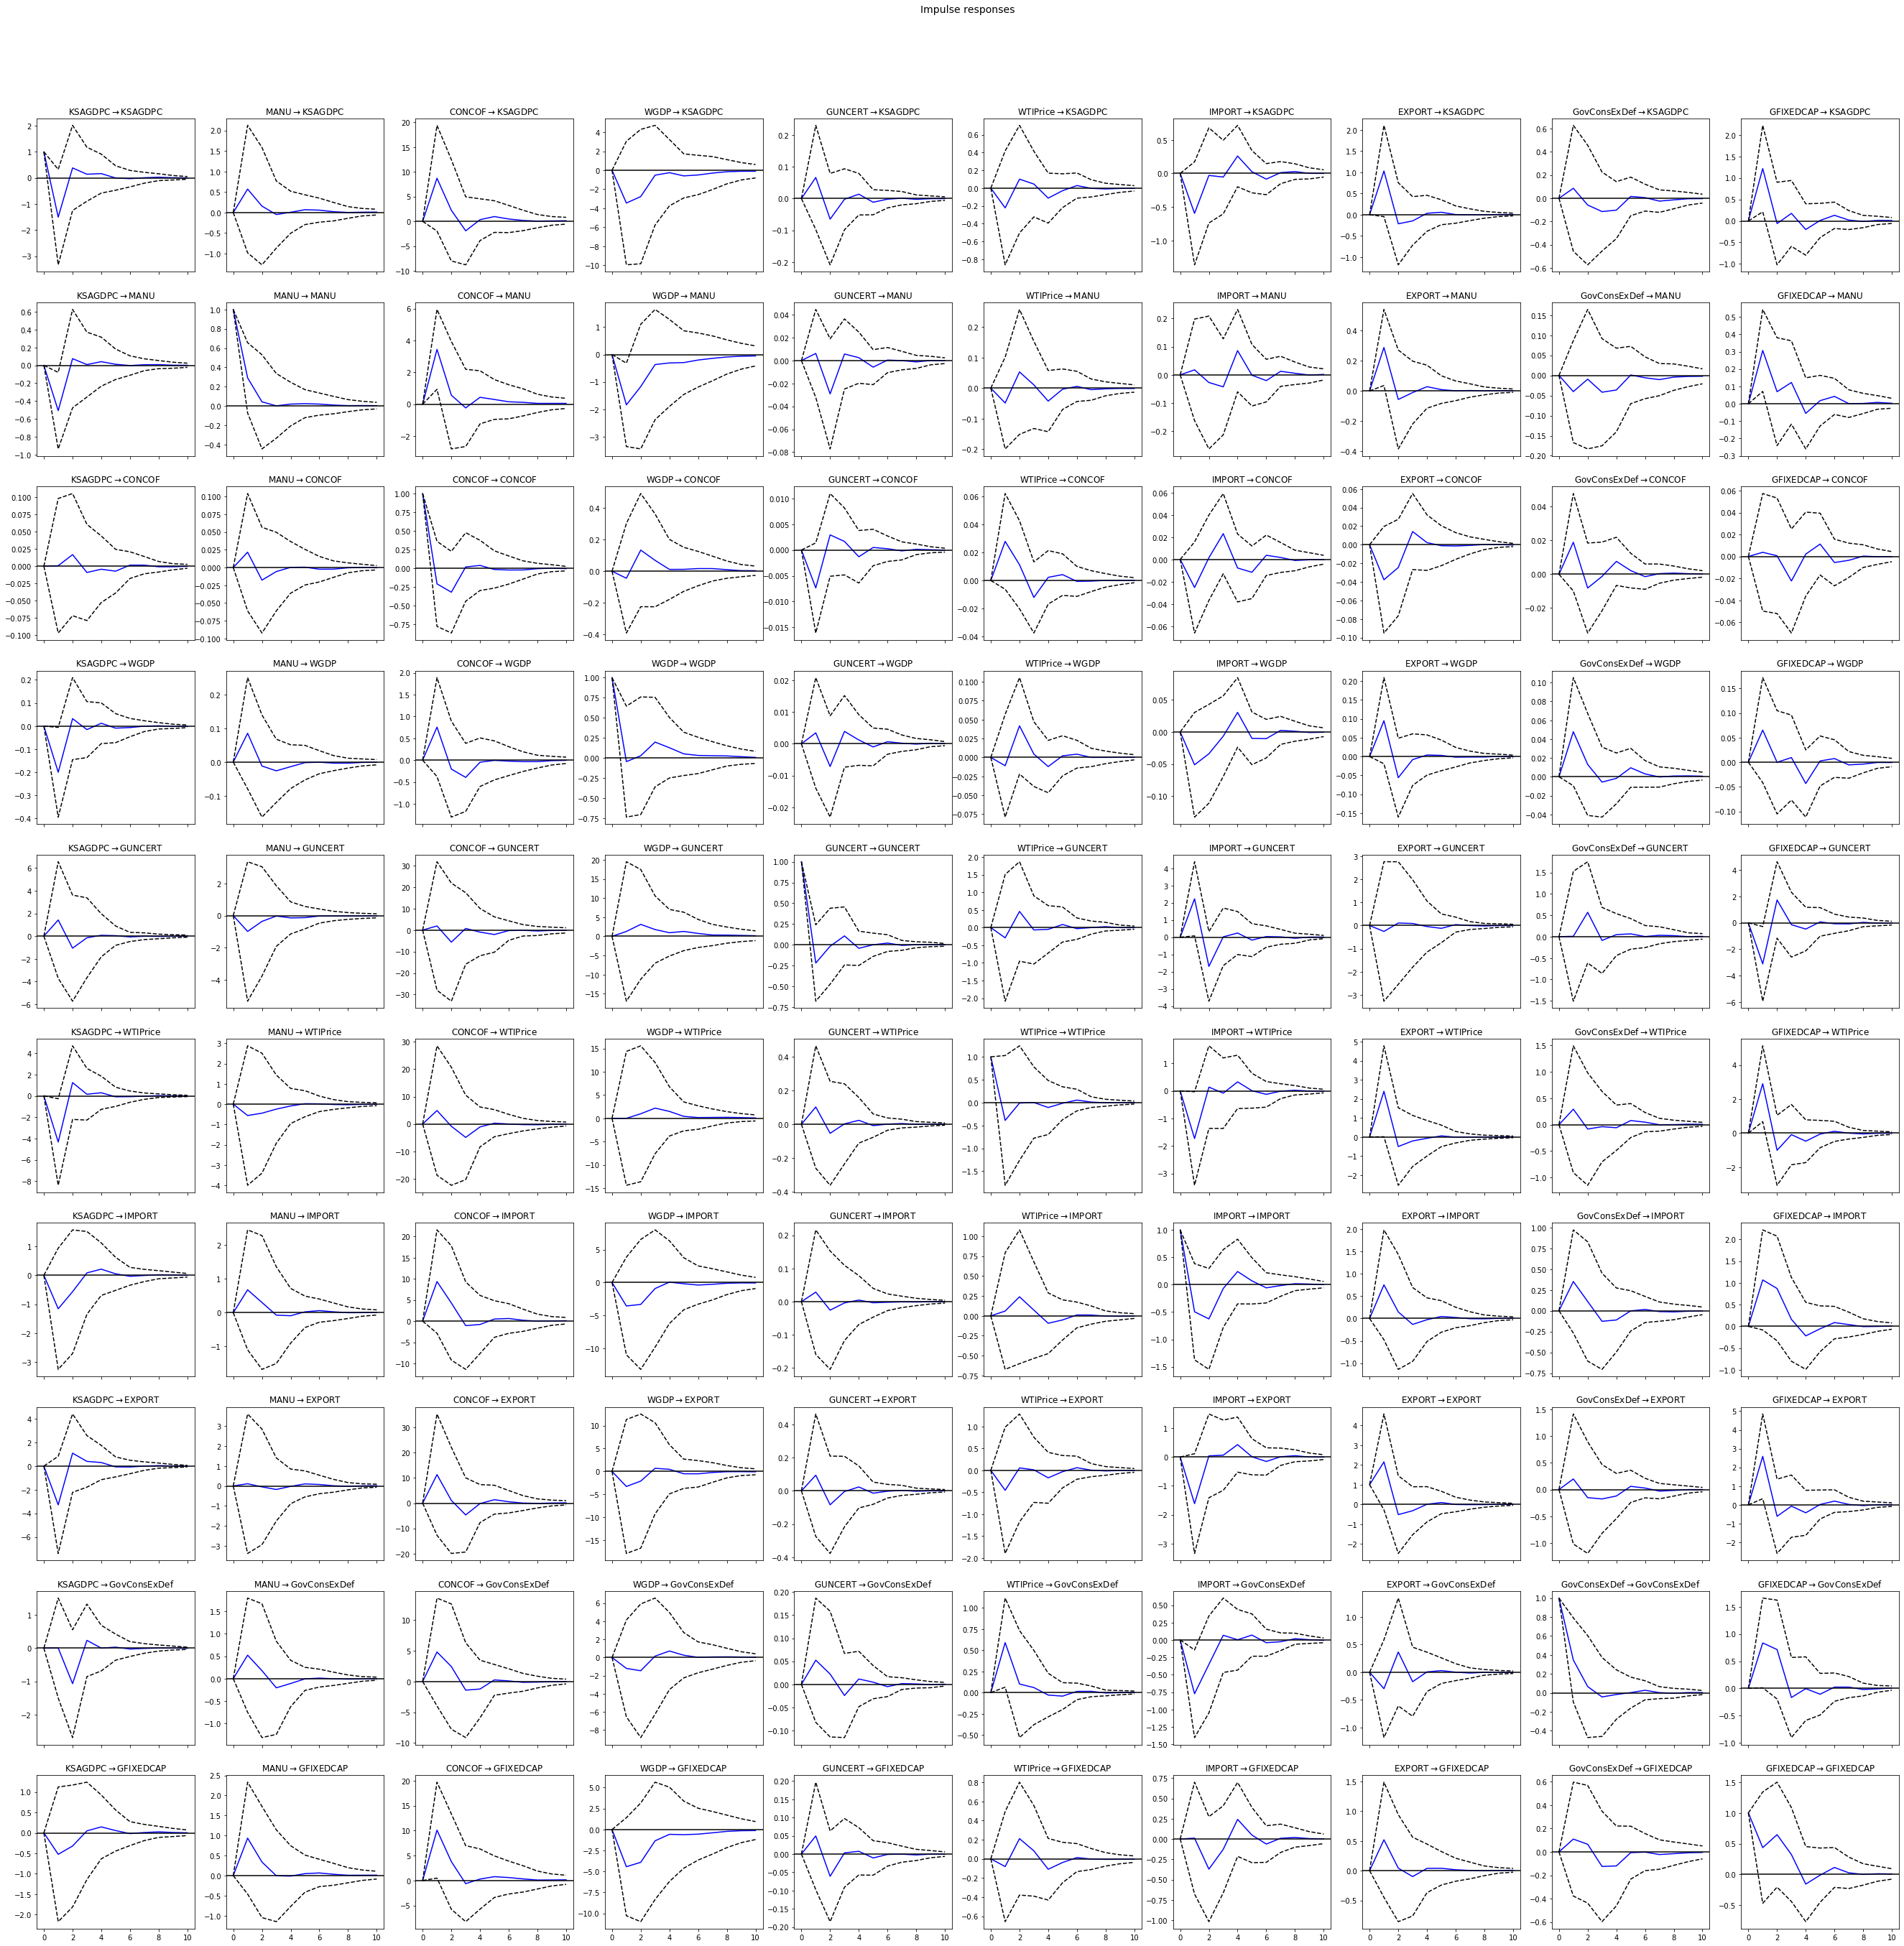

In [78]:
#impulse response function

#We introduce a joint impulse response function (jIRF) that allows for simultaneous shocks 
#from multiple variables in the VAR, rather than one at a time. The jIRF is independent of 
#the order of the variables in the VAR so the response functions are unique. 
#The traditional orthogonal IRF based upon the Cholesky decomposition allows only one 
#originating shock at a time and the response functions are dependent on the specific 
#order of the variables in the VAR. The generalized IRF is order independent but still 
#only allows one originating shock at a time. In many applications, we would like to measure 
#the reaction due to shocks from several variables at a time to estimate, say, the response to 
#policies that affect several economic sectors simultaneously. The jIRF is designed to address 
#these cases.


irf = model_fitted.irf(10)
plot_irf = irf.plot(orth=False)
plot_irf.set_figheight(40)
plot_irf.set_figwidth(40)
plot_irf.savefig('test3.png', dpi = 100)


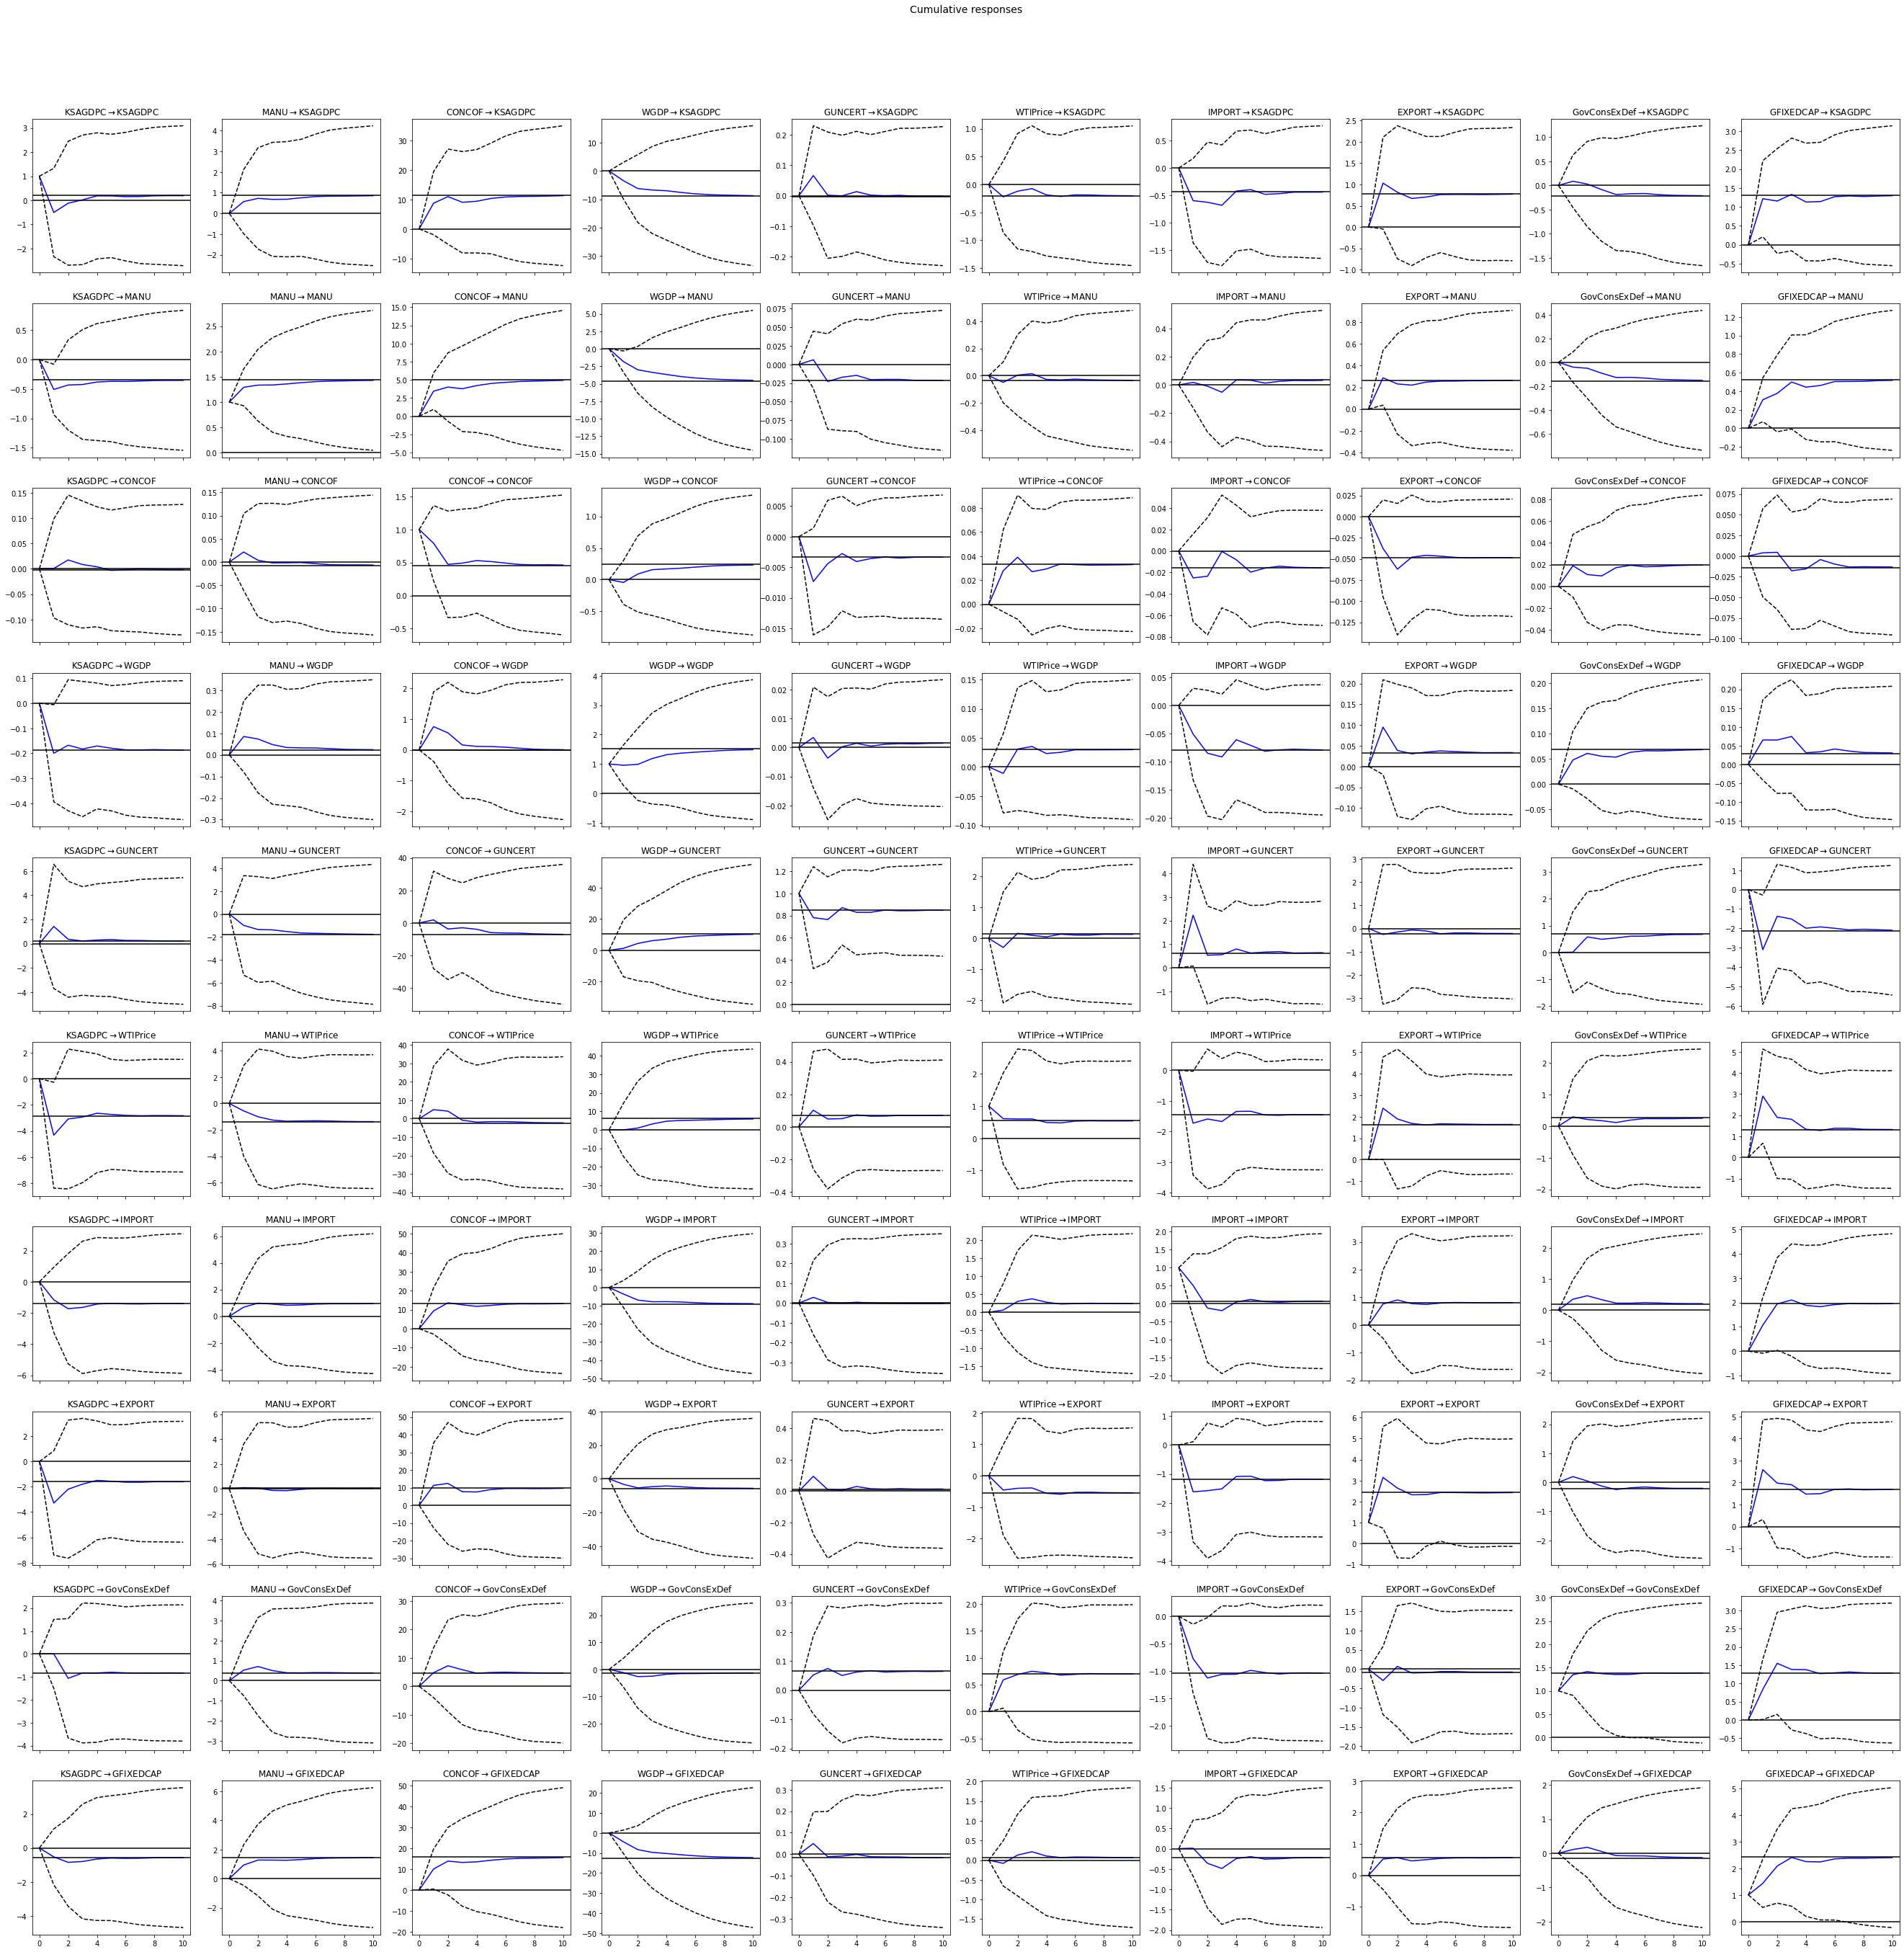

In [79]:
plot_irf_2 = irf.plot_cum_effects(orth=False)
plot_irf_2.set_figheight(40)
plot_irf_2.set_figwidth(40)
plot_irf_2.savefig('test4.png', dpi = 100)


In [80]:
#Compute Monte Carlo integrated error bands assuming normally distributed for impulse response functions

irfmc = model_fitted.irf_errband_mc(orth=False, repl=1000, signif=0.05, seed=None, burn=100, cum=False)

In [81]:
#GFIXEDCAP forecast looks good.
#GOVCONSExDef bottomed before model predicted. Dummy for war or other variables?



#As a next step, tune parameters. Introduce linear interpolation and train VAR until 2017 to forecast the rest.
#Check the expanding vs. rolling window on time periods
#Calculate RMSE, Durban Watson
#Time trend and see if need to detrend
#2015 as structural break dummy variable
#Test the model by imposing restrictions
#Introduce impulse response and see how the system behaves
#Increase
